## About
Over the course of two weeks, I had the opportunity to be as creative as I wanted to be and come up with an idea to leverage the Foursquare location data to explore or compare neighborhoods or cities of my choice or to come up with a problem where I could use the Foursquare location data to solve the problem.
No matter what I've decided to do, I had to make sure to provide sufficient justification of why I thought what I've wanted to do or solve was important and why would a client or a group of people be interested in my project.

<H2>Table of Contents</H2>
1. <a href="#item1">Introduction</a><br>
2. <a href="#item2">Data Overview</a><br>  
3. <a href="#item3">Methodology</a><br>  
4. <a href="#item4">Conclusion</a><br>
5. <a href="#item5">References</a><br>

## 1. Introduction
___

Airbnb is a internet marketplace for short-term home and apartment rentals. It allows you to, for example, rent out your home for a week while you’re away, or rent out your empty bedroom. One challenge that Airbnb hosts face is determining the optimal nightly rent price. In many areas, renters are presented with a good selection of listings and can filter by criteria like price, number of bedrooms, room type, and more. Since Airbnb is a market, the amount a host can charge is ultimately tied to market prices.

### Business Background

Although Airbnb provides hosts with general guidance, there are no easy to access methods to determine the best price to rent out a space. There is third-party software available, but for a hefty price (see an example on available software, click [here](https://beyondpricing.com/)).

One method could be to find a few listings that are similar to the place that will be up for rent, average the listed prices and set our price to this calculated average price. However, with the market being so dynamic, we would probably be looking to update the price regularly and this method can become tedious.

Moreover, this may not be very accurate, as we are not taking into account other important factors that may give us a comparative advantage over other listings around us. This could be property characteristics such as number of rooms, bathrooms and extra services on offer.

The aim of this project is to propose a data-driven solution, by using machine learning to predict rental price.

For this project, a predictor based on space will be introduced to the model: the property's proximity to certain venues. This will allow the model to put an implicit price on things such as living close to a bar or a supermarket.

### Target Audience
Who will be beneficial from this project:
* *Hosts* who are interested to identify the market value for their apartments or rooms
* *Tourists* who would want to compare different hosts to find the best solution for themselves
* *Data Analysts/Scientists* who can view the analysis for this project and can get inspired to implement in other different problems using the techniques and ideas used here.

## 2. Data Overview
___
Airbnb does not release any data on the listings in its marketplace, a but separate group named [Inside Airbnb](http://insideairbnb.com/get-the-data.html) scrapes and compiles publicly available information about many cities Airbnb's listings from the Airbnb web-site. For this project, their data set scraped on June 20, 2020, on the city of Munich, Germany, is used. It contains information on all Munich Airbnb listings that were live on the site on that date (almost 10,000). Here's a direct [link](http://insideairbnb.com/munich/).

The data has certain limitations. The most noticeable one is that it scrapes the advertised price rather than the actual price paid by previous customers. More accurate data is available for a fee in sites like [AirDNA](https://www.airdna.co/).

Each row in the dataset is a listing available for rental in Airbnb's site for the specific city (observations). The columns describe different characteristics of each listing (features).

Some of the more important features this project will look into are the following:

* accommodates: the number of guests the rental can accommodate
* bedrooms: number of bedrooms included in the rental
* bathrooms: number of bathrooms included in the rental
* beds: number of beds included in the rental
* price: nightly price for the rental
* minimum_nights: minimum number of nights a guest can stay for the rental
* maximum_nights: maximum number of nights a guest can stay for the rental
* number_of_reviews: number of reviews that previous guests have left

To model the spatial relationship between Airbnb rental prices and property proximity to certain venues, we use the [Foursquare API](https://developer.foursquare.com/) to access the city's venues and the street network, available through [OpenStreepMap (OSM)](https://www.openstreetmap.org/).

## 3. Methodology
___

**Install required packages**

In [ ]:
# Outputs cleared because of a cleaner view

# Update conda packages
!conda clean --all -y
!conda update --all -y

In [ ]:
# Outputs cleared because of a cleaner view

# Packages needed for installing the libraries
import sys
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install mplleaflet
!{sys.executable} -m pip install bs4
!{sys.executable} -m pip install geocoder
!{sys.executable} -m pip install geopy
!{sys.executable} -m pip install folium
!{sys.executable} -m pip install lxml
!{sys.executable} -m pip install pygeoj
!{sys.executable} -m pip install pyshp
!{sys.executable} -m pip install datetime
!{sys.executable} -m pip install seaborn==0.10.0
!{sys.executable} -m pip install --upgrade cython
!{sys.executable} -m pip install statsmodels

In [ ]:
# Outputs cleared because of a cleaner view

# build a wheel
!{sys.executable} -m pip install bdist-wheel-name
# package to run geopandas
!conda install -c conda-forge libspatialindex -y
# packages for neighbourhood analysis
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install descartes
!{sys.executable} -m pip install requests
!conda install -c conda-forge pandana==0.5 -y

**Import necessary libraries**

In [31]:
#Hide warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from numpy.random import seed
(seed(123))
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
# Geographical analysis
import geopandas as gpd #libspatialindex nees to be installed first
from shapely.geometry import Point
import json # library to handle JSON files
from pandas.io.json import json_normalize
from sklearn import preprocessing
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import ensemble
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import requests
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
# accessibility analysis
import time
from pandana.loaders import osm
from pandana.loaders import pandash5
import shapefile as shp
import datetime
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose
from collections import Counter
%matplotlib inline

print('Libraries Imported')

Libraries Imported


### Cleaning and pre-processing

In [54]:
#!pwd to check the working directory
raw_df = pd.read_csv('listings.csv.gz')
print(f"The dataset contains {len(raw_df)} Airbnb listings")
pd.set_option('display.max_columns', len(raw_df.columns)) # To view all columns
pd.set_option('display.max_rows', 100)
raw_df.head(3)

The dataset contains 11128 Airbnb listings


id                         listing_url       scrape_id last_scraped  \
0  36720  https://www.airbnb.com/rooms/36720  20200524235838   2020-05-25   
1  49309  https://www.airbnb.com/rooms/49309  20200524235838   2020-05-26   
2  97945  https://www.airbnb.com/rooms/97945  20200524235838   2020-05-26   

                                              name  \
0              Beautiful 2 rooms flat, Glockenbach   
1  Sublet - Apartment with Balcony in Downtown (1)   
2                 Deluxw-Apartm. with roof terrace   

                                             summary  \
0  Very quiet, yet centrally located 2 rooms apt....   
1  we are a young family of 4 and will be travell...   
2                                                NaN   

                                               space  \
0  2-Zimmer Altbauwohung Beste Lage, zentral, im ...   
1  we offer one very bright room with balcony, a ...   
2  We offer a modern, quiet apartment with a sunn...   

                                         description experiences_offered  \
0  Very quiet, yet centrally located 2 rooms apt....                none   
1  we are a young family of 4 and will be travell...                none   
2  We offer a modern, quiet apartment with a sunn...                none   

                               neighborhood_overview  \
0  Glockenbachviertel area has the hippest restau...   
1  the neighborhood "schlachthofviertel" is one o...   
2  We are living in a outskirt of Munich its call...   

                                               notes  \
0                                                NaN   
1  please note, that the room has no curtains and...   
2                                                NaN   

                                             transit  \
0  Convenient public transport, walking distance ...   
1  the closest subway stop is "Goetheplatz", wher...   
2  Wir wohnen im Grünen und doch in Stadtnähe, Di...   

                                              access  \
0                                                NaN   
1                                                NaN   
2  Keine Gartenbenutzung. Öffentliche Parkplätze ...   

                                         interaction  \
0                                                NaN   
1  international folks welcome (English, Portugue...   
2  Wir sind gern bereit unseren Gästen unsere Umg...   

                                         house_rules  thumbnail_url  \
0  Please no smoking in the apartment, and be car...            NaN   
1  our house rules: - please let us know in advan...            NaN   
2                             nichtraucher erwünscht            NaN   

   medium_url                                        picture_url  \
0         NaN  https://a0.muscache.com/im/pictures/4e2a8e2e-d...   
1         NaN  https://a0.muscache.com/im/pictures/5578937/1f...   
2         NaN  https://a0.muscache.com/im/pictures/2459996/10...   

   xl_picture_url  host_id                                  host_url  \
0             NaN   158413  https://www.airbnb.com/users/show/158413   
1             NaN   224802  https://www.airbnb.com/users/show/224802   
2             NaN   517685  https://www.airbnb.com/users/show/517685   

  host_name  host_since             host_location  \
0  Gabriela  2010-07-05  Munich, Bavaria, Germany   
1    Damien  2010-09-05   Munich, Bayern, Germany   
2  Angelika  2011-04-18   Munich, Bayern, Germany   

                                          host_about host_response_time  \
0  Hi there, my name is Gabriela. I'm a big trave...                NaN   
1  Hello there! We love meeting new people and tr...       within a day   
2  Ich freue mich auf viele internationale Gäste!...                NaN   

  host_response_rate host_acceptance_rate host_is_superhost  \
0                NaN                  NaN                 f   
1               100%                   0%                 f   
2                NaN                  89%         

**Droping initial columns**

Natural Language Processing will not be used in the creation of this model. Therefore, free text columns will be dropped for now, as will other columns which are not useful for predicting price (e.g. url, host name and other host-related features that are unrelated to the property).

In [55]:
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
df = raw_df.drop(cols_to_drop, axis=1)

**Columns with several NULL entries are dropped too**

In [56]:
df.isna().sum()

id                                                  0
experiences_offered                                 0
host_since                                          7
host_response_time                               7674
host_response_rate                               7674
host_acceptance_rate                             4202
host_is_superhost                                   7
host_listings_count                                 7
host_total_listings_count                           7
host_has_profile_pic                                7
host_identity_verified                              7
street                                              0
neighbourhood                                       0
neighbourhood_cleansed                              0
neighbourhood_group_cleansed                    11128
city                                                0
state                                              64
zipcode                                           233
market                      

In [57]:
df.drop(['host_acceptance_rate', 'neighbourhood_group_cleansed', 'square_feet', 'weekly_price', 'monthly_price', 'license', 'jurisdiction_names'], axis=1, inplace=True)

df.set_index('id', inplace=True)

"host_listings_count" and "host_total_listings_count" are the same in most cases, but those where the value is NaN. Therefore one of these columns can be dropped. Other columns which split these into type of property will also be dropped, as they will be highly correlated (one will be the total of the other).

In [58]:
print(sum((df.host_listings_count == df.host_total_listings_count) == False))
df.loc[((df.host_listings_count == df.host_total_listings_count) == False)][:5]

7


experiences_offered host_since host_response_time host_response_rate  \
id                                                                             
6849110                none        NaN                NaN                NaN   
7186087                none        NaN                NaN                NaN   
8021050                none        NaN                NaN                NaN   
8560341                none        NaN                NaN                NaN   
8604077                none        NaN                NaN                NaN   

        host_is_superhost  host_listings_count  host_total_listings_count  \
id                                                                          
6849110               NaN                  NaN                        NaN   
7186087               NaN                  NaN                        NaN   
8021050               NaN                  NaN                        NaN   
8560341               NaN                  NaN                        NaN   
8604077               NaN                  NaN                        NaN   

        host_has_profile_pic host_identity_verified                   street  \
id                                                                             
6849110                  NaN                    NaN  Munich, Bayern, Germany   
7186087                  NaN                    NaN  Munich, Bayern, Germany   
8021050                  NaN                    NaN  Munich, Bayern, Germany   
8560341                  NaN                    NaN  Munich, Bayern, Germany   
8604077                  NaN                    NaN  Munich, Bayern, Germany   

                neighbourhood neighbourhood_cleansed     city   state zipcode  \
id                                                                              
6849110  Ramersdorf - Perlach     Ramersdorf-Perlach  München  Bayern   81671   
7186087              Sendling               Sendling  München  Bayern   81371   
8021050  Schwabing - Freimann     Schwabing-Freimann  München  Bayern   80803   
8560341           Obergiesing            Obergiesing  München  Bayern   81539   
8604077                  Laim                   Laim  München  Bayern   80689   

         market   smart_location country_code  country  latitude  longitude  \
id                                                                            
6849110  Munich  Munich, Germany           DE  Germany  48.11859   11.62489   
7186087  Munich  Munich, Germany           DE  Germany  48.11619   11.55037   
8021050  Munich  Munich, Germany           DE  Germany  48.16315   11.58195   
8560341  Munich  Munich, Germany           DE  Germany  48.11241   11.58001   
8604077  Munich  Munich, Germany           DE  Germany  48.13029   11.49302   

        is_location_exact property_type        room_type  accommodates  \
id                                                                       
6849110                 f     Apartment  Entire home/apt             3   
7186087                 t     Apartment     Private room             1   
8021050                 t     Apartment  Entire home/apt             2   
8560341                 f     Apartment     Private room             2   
8604077                 f         House  Entire home/apt             4   

         bathrooms  bedrooms  beds  bed_type  \
id                                             
6849110        1.0       2.0   2.0  Real Bed   
7186087        1.0       1.0   1.0  Real Bed   
8021050        1.0       1.0   1.0  Real Bed   
8560341        1.0       1.0   1.0  Real Bed   
8604077        1.5       2.0   4.0  Real Bed   

                                                 amenities    price  \
id                                                                    
6849110  {TV,"Cable TV",Internet,Wifi,Kitchen,"Buzzer/w...   $55.00   
7186087                                                 {}   $35.00   
8021050  {TV,Kitchen,"Buzzer/wireless intercom",Heating...  $120.00   
8560341  {Wif

In [59]:
df.drop(['host_total_listings_count', 'calculated_host_listings_count', 
         'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 
         'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)

In [60]:
lat_long = df[['latitude', 'longitude']]

In [61]:
df.drop(['zipcode', 'latitude', 'longitude', 'street', 'neighbourhood', 'city', 
         'state', 'market', 'smart_location', 'country_code', 'country', 'is_location_exact'], axis=1, inplace=True)

There are multiple columns for "minimum" and "maximum night stays", but the two main ones will be used as there are few differences between e.g. "minimum_nights" and "minimum_minimum_nights". The latter presumably refers to the fact that "min/max night stays" can vary over the year. The default (i.e. most frequently applied) "min/max night stay" values will be used instead.

In [62]:
sum((df.minimum_nights == df.minimum_minimum_nights) == False)

236

In [63]:
df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 
         'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

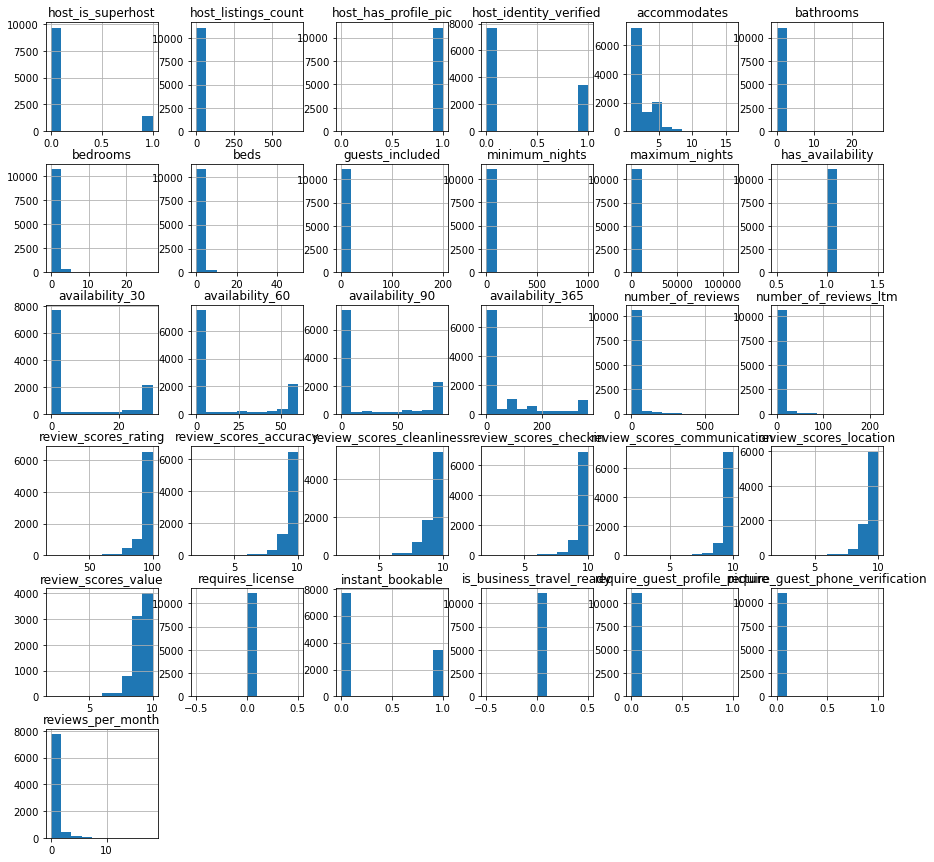

In [64]:
# Replacing columns with f/t with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
df.hist(figsize=(15,15));

From the above, we can  see that several columns only contain one category and they can be dropped:

In [65]:
df.drop(['has_availability', 'is_business_travel_ready', 
         'require_guest_phone_verification', 'require_guest_profile_picture', 'requires_license'], axis=1, inplace=True)

_**Description of each column**_:

* experiences_offered - slightly unclear as it does not appear to directly relate to Airbnb Experiences, but this seems to be the main recommended category of travel type, e.g. business
* host_since - date that the host first joined Airbnb
* host_response_time - average amount of time the host takes to reply to messages
* host_response_rate - proportion of messages that the host replies to
* host_is_superhost - whether or not the host is a superhost, which is a mark of quality for the top-rated and most experienced hosts, and can increase your search ranking on Airbnb
* host_listings_count - how many listings the host has in total
* host_identity_verified - whether or not the host has been verified with id
* neighbourhood_cleansed - the London borough the property is in
* property_type - type of property, e.g. house or flat
* room_type - type of listing, e.g. entire home, private room or shared room
* accommodates - how many people the property accommodates
* bathrooms - number of bathrooms
* bedrooms - number of bedrooms
* beds - number of beds
* bed_type - type of bed, e.g. real bed or sofa-bed
* amenities - list of amenities
* price - nightly advertised price (the target variable)
* security_deposit - the amount required as a security deposit
* cleaning_fee - the amount of the cleaning fee (a fixed amount paid per booking)
* guests_included - the number of guests included in the booking fee
* extra_people - the price per additional guest above the guests_included price
* minimum_nights - the minimum length of stay
* maximum_nights - the maximum length of stay
* calendar_updated - when the host last updated the calendar
* availability_30 - how many nights are available to be booked in the next 30 days
* availability_60 - how many nights are available to be booked in the next 60 days
* availability_90 - how many nights are available to be booked in the next 90 days
* availability_365 - how many nights are available to be booked in the next 365 days
* number_of_reviews - the number of reviews left for the property
* number_of_reviews_ltm - the number of reviews left for the property in the last twelve months
* first_review - the date of the first review
* last_review - the date of the most recent review
* review_scores_rating - guests can score properties overall from 1 to 5 stars
* review_scores_accuracy - guests can score the accuracy of a property's description from 1 to 5 stars
* review_scores_cleanliness - guests can score a property's cleanliness from 1 to 5 stars
* review_scores_checkin - guests can score their check-in from 1 to 5 stars
* review_scores_communication - guests can score a host's communication from 1 to 5 stars
* review_scores_location - guests can score a property's location from 1 to 5 stars
* review_scores_value - guests can score a booking's value for money from 1 to 5 stars
* instant_bookable - whether or not the property can be instant booked (i.e. booked straight away, without having to message the host first and wait to be accepted)
* cancellation_policy - the type of cancellation policy, e.g. strict or moderate
* reviews_per_month - calculated field of the average number of reviews left by guest each month

**Cleaning individual columns**

__*experiences_offered*__

Most listings offer no experienes, so this feature can be dropped

In [66]:
df.experiences_offered.value_counts()

none    11128
Name: experiences_offered, dtype: int64

In [1]:
df.drop('experiences_offered', axis=1, inplace=True)

NameError: name 'df' is not defined

__*host_since*__

This datetime column will be converted into a measure of the number of days that a host has been on the platform, measured from the date that the data was scraped (June 20, 2020). The original column will be left in initially for EDA, and dropped later.

In [68]:
# Converting to datetime
df.host_since = pd.to_datetime(df.host_since) 

# Calculating the number of days
df['host_days_active'] = (pd.datetime(2020, 6, 20) - df.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(df['host_days_active'].mean(),0))
print("Median days as host:", df['host_days_active'].median())

# Replacing null values with the median
df.host_days_active.fillna(df.host_days_active.median(), inplace=True)

Mean days as host: 1651.0
Median days as host: 1737.0


__*host_response_time*__

About two thirds of rows don't have a value for host_response_time, and a lot of these have also not yet been reviewed. Therefore this section of the data set consists primarily of properties which have not yet had a completed stay (most likely properties which have not yet had a booking, although may also include properties that have a booking currently occuring). Although this is a considerable proportion of the dataset, these listings will be retained in the data because they are still legitimate properties with advertised prices, and are still part of the comparative market when considering the price for which to advertise your Airbnb listing. However, if the dataset being used had the actual average price paid as its target, it would be necessary to drop these rows because they would not have a value, as they have not yet been booked.

It is worth nothing, however, that this group of listings probably also contains a large number of 'inactive' listings. These are properties which have been speculatively listed on Airbnb but either have their calendars closed (so no stays can be booked), or have prices which are notably higher than other properties in their area. Because "host_response_time" is unknown for so many listings, it will be retained as its own category, 'unknown'.

In [69]:
print("Null values:", df.host_response_time.isna().sum())
print(f"Proportion: {round((df.host_response_time.isna().sum()/len(df))*100, 1)}%")

# Number of rows without a value for host_response_time which have also not yet had a review
len(df[df.loc[ :,['host_response_time', 'first_review'] ].isnull().sum(axis=1) == 2])

Null values: 7674
Proportion: 69.0%


2052

In [70]:
df.host_response_time.fillna("unknown", inplace=True)
df.host_response_time.value_counts(normalize=True)

unknown               0.689612
within an hour        0.141175
within a day          0.075306
within a few hours    0.068476
a few days or more    0.025431
Name: host_response_time, dtype: float64

__*host_response_rate*__

A similar story is true for "host_response_rate", with about two thirds of values being null. This will also be kept as its own category, after grouping other values into meaningful groups (i.e. transforming this into a categorical feature, rather than a numerical one). Because about 70% of hosts respond 100% of the time, this will be kept as its own category, and other values will be grouped into bins.

In [71]:
print("Null values:", df.host_response_rate.isna().sum())
print(f"Proportion: {round((df.host_response_rate.isna().sum()/len(df))*100, 1)}%")

Null values: 7674
Proportion: 69.0%


In [72]:
# Removing the % sign from the "host_response_rate" string and converting it to an integer
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')
print("Mean host response rate:", round(df['host_response_rate'].mean(),0))
print("Median host response rate:", df['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((df.host_response_rate == 100.0).sum()/df.host_response_rate.count())*100,1)}%")

Mean host response rate: 87.0
Median host response rate: 100.0
Proportion of 100% host response rates: 70.7%


In [73]:
# Bin into four categories
df.host_response_rate = pd.cut(df.host_response_rate, 
                               bins=[0, 50, 90, 99, 100], 
                               labels=['0-49%', '50-89%', '90-99%', '100%'], 
                               include_lowest=True)

# Converting to string
df.host_response_rate = df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
df.host_response_rate.value_counts()

unknown    7674
100%       2441
50-89%      585
0-49%       385
90-99%       43
Name: host_response_rate, dtype: int64

__*host_is_superhost*__

There are 7 rows without values for each of the different host-related features. These rows will be dropped.

In [75]:
# Number of rows without a value for multiple host-related columns
len(df[df.loc[ :,['host_since', 'host_is_superhost', 'host_listings_count', 'host_has_profile_pic', 'host_identity_verified'] ].isnull().sum(axis=1) == 5])

7

In [26]:
df.dropna(subset=['host_since'], inplace=True)

__*property_type*__

Some cleaning of property types is required as there are a large number of categories with only a few listings. The categories "Apartment", "House" and "Other" will be used, as most properties can be classified as either apartment or house.

In [27]:
df.property_type.value_counts()

Apartment                 9614
House                      391
Condominium                311
Serviced apartment         190
Loft                       148
Townhouse                  130
Hotel                       60
Boutique hotel              47
Other                       31
Aparthotel                  26
Hostel                      23
Bed and breakfast           22
Bungalow                    22
Guest suite                 21
Camper/RV                   21
Tent                        11
Tiny house                  10
Guesthouse                   9
Villa                        7
Hut                          7
Nature lodge                 5
Bus                          4
Tipi                         2
Earth house                  2
Farm stay                    1
Casa particular (Cuba)       1
Igloo                        1
Cabin                        1
Cave                         1
Boat                         1
Castle                       1
Name: property_type, dtype: int64

In [28]:
# Replacing categories that are types of houses or apartments
df.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House'
    }, inplace=True)

# Replacing other categories with 'other'
df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

__*bathrooms, bedrooms and beds*__

Missing values will be replaced with median to avoid strange fractions.

In [29]:
for col in ['bathrooms', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)

__*bed_type*__

Most listings have the same bed type, so it won't constitute a comparative advantage to have this feature. So this feature can be dropped.

In [30]:
df.bed_type.value_counts()

Real Bed         10680
Pull-out Sofa      296
Couch               68
Futon               56
Airbed              21
Name: bed_type, dtype: int64

In [31]:
df.drop('bed_type', axis=1, inplace=True)

__*amenities*__

"Amenities" is a list of additional features in the property, i.e. whether it has a TV or parking. 

In [32]:
# Creating a set of possible amenities
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)

In the list above, some amenities are more important than others, and some are likely to be fairly uncommon. Amenities will be extracted based on quick research into which amenities are considered by guests, a selection of the more important as well as personal experience. These will be further investigated in the EDA section. For example, if it turns out that almost all properties have/do not have a particular amenity, that feature will not be very useful in helping explain differences in prices.

In [33]:
df.loc[df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
df.loc[df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

One way to reduce the number of features is to remove the amenities which add relatively little information, or are relatively unhelpful in differentiating between different listings. Amenity features where either the true or the false category contains fewer than 10% of listings will be removed.

In [34]:
# Replacing nulls with zeros for new columns
replace_nulls = df.iloc[:,41:].columns
df[replace_nulls] = df[replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in df.iloc[:,41:].columns:
    if df[col].sum() < len(df)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
df.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
df.drop('amenities', axis=1, inplace=True)

['check_in_24h', 'air_conditioning', 'high_end_electronics', 'bbq', 'nature_and_views', 'breakfast', 'gym', 'outdoor_space', 'hot_tub_sauna_or_pool', 'secure', 'self_check_in', 'accessible', 'event_suitable']


In [35]:
df.columns[40:]

Index(['balcony', 'bed_linen', 'tv', 'coffee_machine', 'cooking_basics',
       'white_goods', 'elevator', 'child_friendly', 'parking', 'host_greeting',
       'internet', 'long_term_stays', 'pets_allowed', 'private_entrance',
       'smoking_allowed'],
      dtype='object')

__*price*__

"price" is a string because there is a currency sign. It will be converted to an integer.

In [36]:
df.price = df.price.str[1:-3]
df.price = df.price.str.replace(",", "")
df.price = df.price.astype('int64')

__*security_deposit, cleaning_fee, extra_people*__

These columns will also be converted to an integer.
Having a missing value is functionally the same as having a security deposit or fee of $0, so missing values will be replaced with 0.

In [37]:
df.security_deposit = df.security_deposit.str[1:-3]
df.security_deposit = df.security_deposit.str.replace(",", "")
df.security_deposit.fillna(0, inplace=True)
df.security_deposit = df.security_deposit.astype('int64')

In [38]:
df.cleaning_fee = df.cleaning_fee.str[1:-3]
df.cleaning_fee = df.cleaning_fee.str.replace(",", "")
df.cleaning_fee.fillna(0, inplace=True)
df.cleaning_fee = df.cleaning_fee.astype('int64')

In [39]:
df.extra_people = df.extra_people.str[1:-3]
df.extra_people = df.extra_people.str.replace(",", "")
df.extra_people.fillna(0, inplace=True)
df.extra_people = df.extra_people.astype('int64')

__*calendar_updated*__

It is not entirely clear what this feature is adding to the model as a host might update their calendar for multiple different reasons, therefore this column will be dropped.



In [40]:
print("Number of categories:", df.calendar_updated.nunique())
print("\nTop five categories:")
df.calendar_updated.value_counts()[:5]

Number of categories: 89

Top five categories:


3 months ago    1298
8 months ago     854
4 months ago     756
9 months ago     563
today            545
Name: calendar_updated, dtype: int64

In [41]:
df.drop('calendar_updated', axis=1, inplace=True)

__*availability*__

Only one measure of availability will be retained, the availability for 90 days (availability_90). This is due to the Government regulations (90 days per year rents).

In [42]:
df.drop(['availability_30', 'availability_60', 'availability_365'], axis=1, inplace=True)

__*first_review*__ and __*last_review*__

About 25% have not had a review written for them. However, the proportion is too large of the dataset to drop, and a lot of useful information would be lost because reviews are very important in people's decisions to book, and therefore price.

This is also too large a proportion of the dataset to simply replace with median/mean values, as this would skew the distribution substantially. Also, the missing values here are not really missing values, as the fact that they are NaNs is meaningful - it tells us that these are new or previously unbooked listings that have not had reviews yet. In order to make the resulting model be able to predict prices for any Airbnb listing, including brand new listings, it is actually beneficial to keep them in. Therefore, these will be kept as an unknown category, and the feature will have to be treated as categorical (and therefore one-hot encoded) rather than numerical.

In [43]:
print(f"Null values in 'first_review': {round(100*df.first_review.isna().sum()/len(df),1)}%")
print(f"Null values in 'review_scores_rating': {round(100*df.review_scores_rating .isna().sum()/len(df),1)}%")

Null values in 'first_review': 24.1%
Null values in 'review_scores_rating': 25.8%


In [44]:
# Convert to datetime
df.first_review = pd.to_datetime(df.first_review)

# Calculate the number of days between the first review and the date the data was scraped
df['time_since_first_review'] = (pd.datetime(2019, 4, 9) - df.first_review).astype('timedelta64[D]')

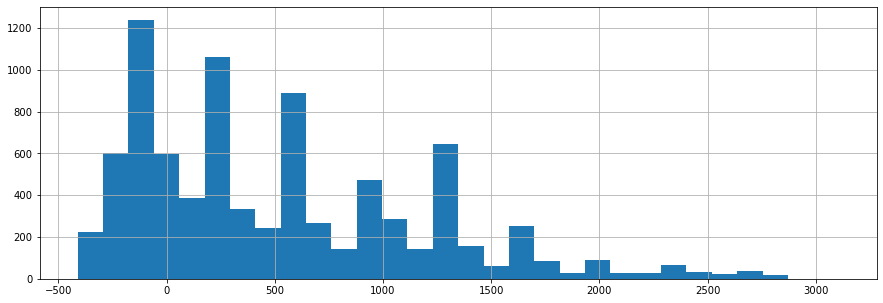

In [45]:
# Distributing the number of days since first review
df.time_since_first_review.hist(figsize=(15,5), bins=30);

In [46]:
def bin_column(col, bins, labels, na_label='unknown'):
    """ Takes in a column name, bin cut points and labels, replaces the original column 
    with a binned version, and replaces nulls (with 'unknown' if unspecified). """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

In [47]:
# Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(df.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

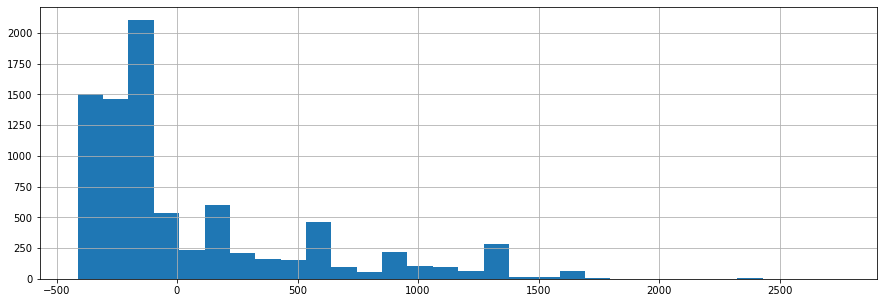

In [48]:
# Same process for "last_review"
df.last_review = pd.to_datetime(df.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
df['time_since_last_review'] = (pd.datetime(2019, 4, 9) - df.last_review).astype('timedelta64[D]')

# Distribution of the number of days since last review
df.time_since_last_review.hist(figsize=(15,5), bins=30);

In [49]:
# Binning time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(df.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

In [50]:
# Dropping "last_review" - "first_review" will be kept for EDA and dropped later
df.drop('last_review', axis=1, inplace=True)

__*review ratings columns*__

Listings without reviews will be kept and replaced with unknown. Other ratings will be grouped into bins. The histograms below were produced in order to decide on useful bins. The majority of ratings are 9 or 10 out of 10, as also seen in the value count below. Therefore for these columns, 9/10 and 10/10 will be kept as separate groups, and 1-8/10 will be binned together, as this is a 'low' rating, by Airbnb standards.

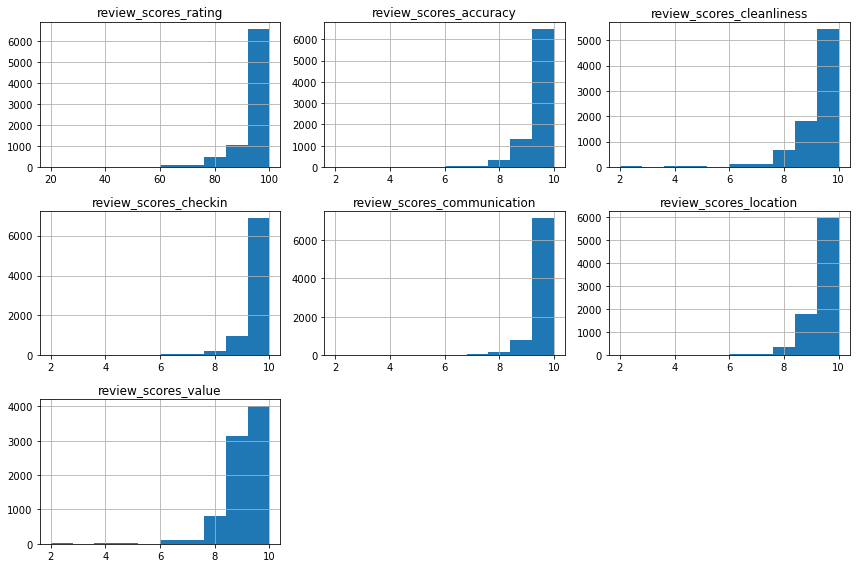

In [51]:
# Checking the distributions of the review ratings columns
plotted_variables = list(df.columns[df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(plotted_variables):
    ax = fig.add_subplot(3,3,i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [52]:
# Create a list of all columns that are scored out of 10
plotted_variables.pop(0)

'review_scores_rating'

In [53]:
# Binning for all columns that scored out of 10
for col in plotted_variables:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

In [54]:
# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

__*cancellation_policy*__

Cleaning of cancellation policy types is required, so that we can categorise the four small categories into three larger categories (e.g. the super strict options are only available to long-term Airbnb hosts, and is invitation only).

In [55]:
df.cancellation_policy.value_counts()

flexible                       4593
moderate                       3296
strict_14_with_grace_period    3226
super_strict_30                   3
super_strict_60                   2
strict                            1
Name: cancellation_policy, dtype: int64

In [56]:
# Replace categories
df.cancellation_policy.replace({
    'super_strict_30': 'strict_14_with_grace_period',
    'super_strict_60': 'strict_14_with_grace_period',
    'strict': 'strict_14_with_grace_period',
    'luxury_moderate': 'moderate'
    }, inplace=True)

__*number_of_reviews_ltm*__ and __*reviews_per_month*__

These columns will be highly correlated with "number_of_reviews", so they will be dropped.

In [57]:
df.drop(['number_of_reviews_ltm', 'reviews_per_month'], axis=1, inplace=True)

In [58]:
df.dtypes

host_since                     datetime64[ns]
host_response_time                     object
host_response_rate                     object
host_is_superhost                     float64
host_listings_count                   float64
host_identity_verified                float64
neighbourhood_cleansed                 object
property_type                          object
room_type                              object
accommodates                            int64
bathrooms                             float64
bedrooms                              float64
beds                                  float64
price                                   int64
security_deposit                        int64
cleaning_fee                            int64
guests_included                         int64
extra_people                            int64
minimum_nights                          int64
maximum_nights                          int64
availability_90                         int64
number_of_reviews                 

In [59]:
# Save cleaned dataset
listings_cleaned = df.to_csv(r'listings_cleaned.csv', index=id, header=True)

### Exloratory Data Analysis

**Time Series**

Time is an important factor to consider in a model when we would like to predict prices or trends. 
A time series is a series of data points ordered in time. In a time series, time is often the independent variable and the goal is usually to make a forecast for the future. There are also other questions that come to play when dealing with time series. For example: Is there any seasonality to the price? Is it stationary? Even though we may not be able to include this aspect into our model, it is good to explore it to be aware of it and be able to make recommendations for future research. Thus, in this section, we will explore this aspect of the data.

For Airbnb prices, a high level of seasonality is expected due to the characteristics of the market. In October, during the *Oktoberfest*, room rental price rises considerably. It is an extremely popular event and much of the rented property available will have been taken up due to the number of people who attend each year. Munich has lots of other events throughout the year, mainly focused between March and December.

In [60]:
# Read the cleansed dataset
df = pd.read_csv('listings_cleaned.csv', index_col=0)

In [61]:
df['host_since'] = pd.to_datetime(df['host_since'])
df['first_review'] = pd.to_datetime(df['first_review'])

In [62]:
print(f"Of all the Airbnb hosts that are still listing on the site, the first joined on {min(df.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(df.host_since).strftime('%d %B %Y')}.")

Of all the Airbnb hosts that are still listing on the site, the first joined on 09 September 2009, and the most recent joined on 24 May 2020.


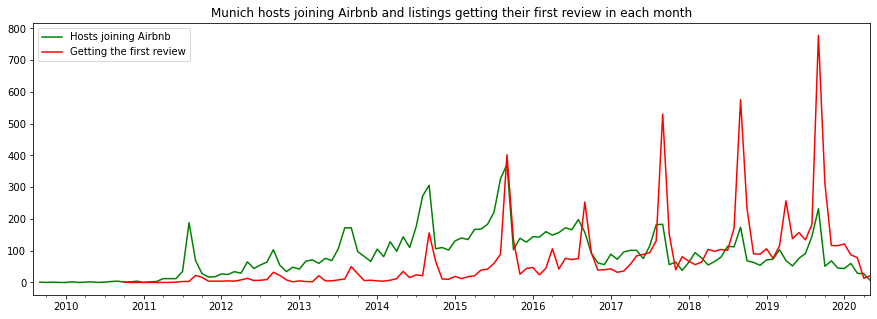

In [63]:
plt.figure(figsize=(15,5))
df.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='green')
df.set_index('first_review').resample('MS').size().plot(label='Getting the first review', color='red')
plt.title('Munich hosts joining Airbnb and listings getting their first review in each month')
plt.legend()
plt.xlim('2009-08-20', '2020-05-20') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

In [64]:
# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(df.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(df.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [65]:
def decompose_time_series(df, title=''):
    """Plots the original time series and its decomposition into trend, seasonal and residual."""
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

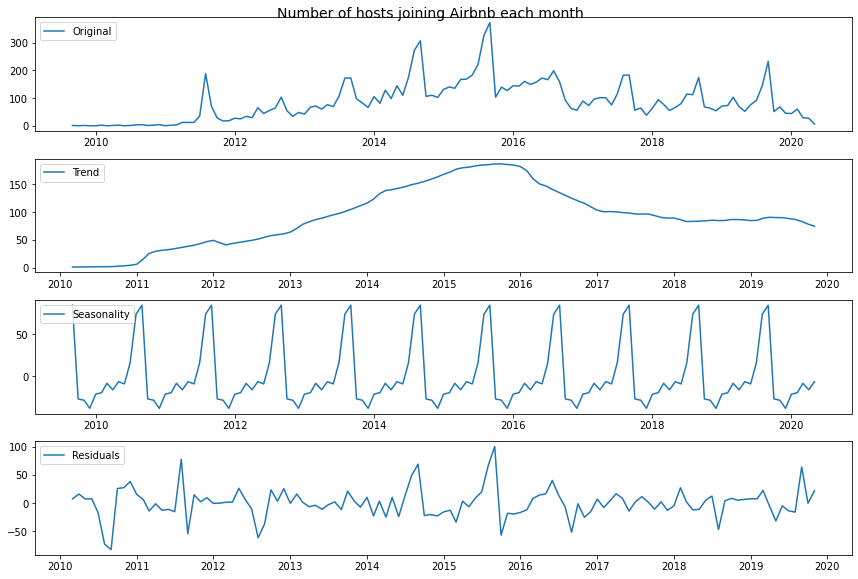

In [66]:
decompose_time_series(ts_host_since, title='Number of hosts joining Airbnb each month')

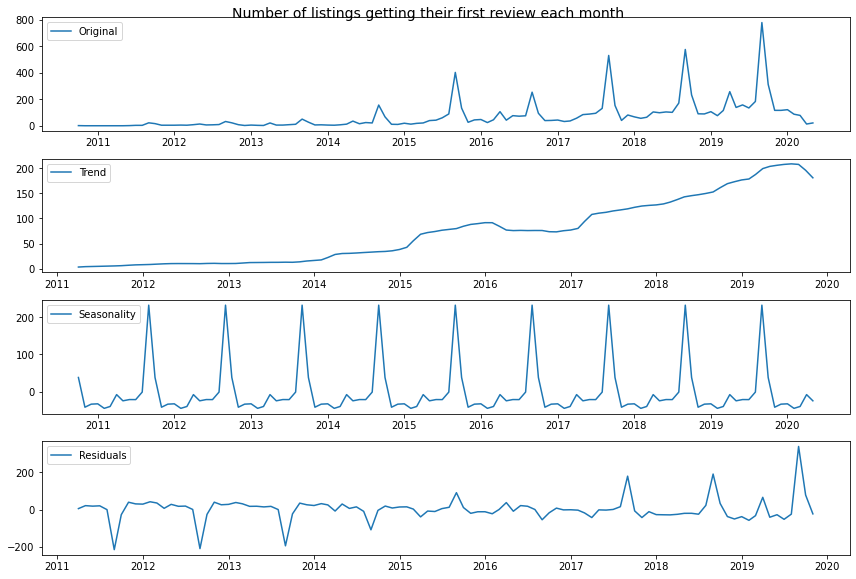

In [67]:
decompose_time_series(ts_first_review, title='Number of listings getting their first review each month')

We can see above that there is a clear seasonality. Every year, you see a peak towards hosts joining around the middle of the second half of the year (summer/fall), and the lowest points are the beginning and the end of each year. There is a big peak in the number of hosts joining Airbnb between 2014-2015 and 2015-2016. Indeed, there has been a fast growth of Airbnb since middle 2014, with clear peaks during Munich's *Oktoberfest*. This was around the time when Airbnb became increasingly popular for short-term lease, as a way to get around local legislation and taxation.

Another important pattern to observe is the number of listings per host. There are a number of professional Airbnb management companies which host a large number of listings under a single host profile. However, there is no consistent upwards trend in the average number of properties managed by each host.

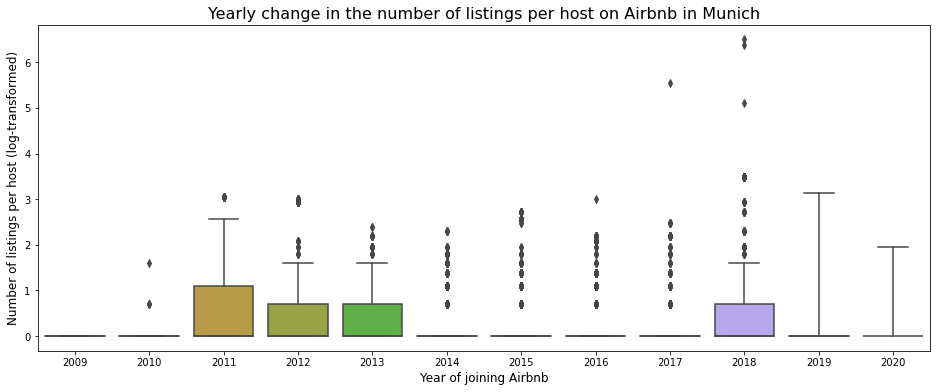

In [68]:
plt.figure(figsize=(16,6))
sns.boxplot(df.host_since.dt.year, np.log(df.host_listings_count))
plt.xlabel('Year of joining Airbnb', fontsize=12)
plt.ylabel('Number of listings per host (log-transformed)', fontsize=12)
plt.title('Yearly change in the number of listings per host on Airbnb in Munich', fontsize=16)
plt.show()

In [69]:
print("Average number of listings per year in Munich:")
print(round(df.set_index('host_since').host_listings_count.resample('YS').mean(),2))

Average number of listings per year in Munich:
host_since
2009-01-01    1.00
2010-01-01    1.35
2011-01-01    3.56
2012-01-01    2.56
2013-01-01    1.48
2014-01-01    1.35
2015-01-01    1.50
2016-01-01    1.34
2017-01-01    1.67
2018-01-01    4.39
2019-01-01    1.58
2020-01-01    1.00
Freq: AS-JAN, Name: host_listings_count, dtype: float64


In [70]:
# List of the largest host_listings_count and the year the host joined Airbnb
df.sort_values('host_listings_count').drop_duplicates('host_listings_count',keep='last').tail(10)[['host_since', 'host_listings_count']]

host_since  host_listings_count
id                                      
42361494 2015-12-21                 15.0
19514142 2012-05-01                 19.0
21860051 2012-10-17                 20.0
1278303  2011-08-17                 21.0
38727361 2019-09-06                 23.0
36045663 2018-07-29                 33.0
34932907 2018-12-05                166.0
40601585 2017-11-17                256.0
37698414 2018-10-11                585.0
30856725 2018-09-03                666.0

In term of changes in prices over time, the average price per night for Airbnb listings in Munich has increased slightly over the last 10 years. In particular, the top end of property prices has increased, resulting in a larger increase in the mean price compared to the median. The mean price in 2011 was €76.92 and the median €59.0, whereas the mean price in 2019 (the last complete year of data) was €120.39 and the median €79.0.

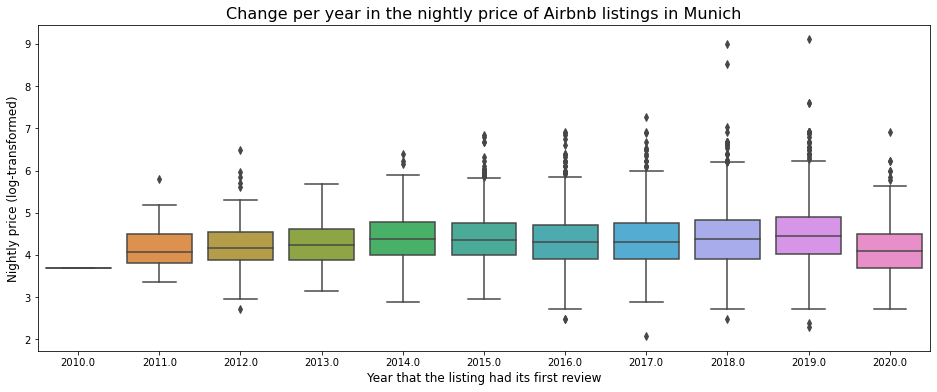

In [71]:
plt.figure(figsize=(16,6))
sns.boxplot(df.first_review.dt.year, np.log(df.price))
plt.xlabel('Year that the listing had its first review', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings in Munich', fontsize=16)
plt.show()

In [72]:
print("Mean nightly price of listings in each year in Munich:")
print(round(df.set_index('first_review').price.resample('YS').mean(),2))

Mean nightly price of listings in each year in Munich:
first_review
2010-01-01     40.00
2011-01-01     76.92
2012-01-01     84.46
2013-01-01     82.61
2014-01-01    101.65
2015-01-01    102.51
2016-01-01    100.22
2017-01-01     98.60
2018-01-01    115.13
2019-01-01    120.39
2020-01-01     81.47
Name: price, dtype: float64


In [73]:
print("Median nightly price of listings in each year in Munich:")
print(round(df.set_index('first_review').price.resample('YS').median(),2))

Median nightly price of listings in each year in Munich:
first_review
2010-01-01    40.0
2011-01-01    59.0
2012-01-01    64.5
2013-01-01    68.5
2014-01-01    80.0
2015-01-01    78.0
2016-01-01    75.0
2017-01-01    75.0
2018-01-01    80.0
2019-01-01    85.0
2020-01-01    60.0
Name: price, dtype: float64


In [74]:
# Drop "host_since" and "first_review" since they are no longer needed
df.drop(['host_since', 'first_review'], axis=1, inplace=True)

**Numerical Features**

In [75]:
df.describe()

host_is_superhost  host_listings_count  host_identity_verified  \
count       11121.000000         11121.000000            11121.000000   
mean            0.129305             1.862422                0.307886   
std             0.335552             9.340865                0.461640   
min             0.000000             0.000000                0.000000   
25%             0.000000             1.000000                0.000000   
50%             0.000000             1.000000                0.000000   
75%             0.000000             2.000000                1.000000   
max             1.000000           666.000000                1.000000   

       accommodates     bathrooms      bedrooms          beds         price  \
count  11121.000000  11121.000000  11121.000000  11121.000000  11121.000000   
mean       2.640410      1.111995      1.084165      1.511555    116.270030   
std        1.493601      0.598842      0.824055      1.333262    215.375862   
min        1.000000      0.000000      0.000000      0.000000      8.000000   
25%        2.000000      1.000000      1.000000      1.000000     52.000000   
50%        2.000000      1.000000      1.000000      1.000000     80.000000   
75%        3.000000      1.000000      1.000000      2.000000    127.000000   
max       16.000000     27.000000     27.000000     50.000000  12000.000000   

       security_deposit  cleaning_fee  guests_included  extra_people  \
count      11121.000000  11121.000000     11121.000000  11121.000000   
mean         176.272637     21.311573         1.356083     13.024548   
std          405.983977     30.793253         2.777931     20.678653   
min            0.000000      0.000000         1.000000      0.000000   
25%            0.000000      0.000000         1.000000      0.000000   
50%            0.000000     15.000000         1.000000      0.000000   
75%          200.000000     30.000000         1.000000     20.000000   
max         4567.000000    500.000000       200.000000    275.000000   

       minimum_nights  maximum_nights  availability_90  number_of_reviews  \
count    11121.000000    11121.000000     11121.000000       11121.000000   
mean         5.766658      614.797051        24.394929          15.352217   
std         26.756475     1282.252675        36.752235          40.648758   
min          1.000000        1.000000         0.000000           0.000000   
25%          1.000000       16.000000         0.000000           1.000000   
50%          2.000000     1125.000000         0.000000           3.000000   
75%          3.000000     1125.000000        60.000000          12.000000   
max       1000.000000   111360.000000        90.000000         688.000000   

       instant_bookable  host_days_active       balcony     bed_linen  \
count      11121.000000      11121.000000  11121.000000  11121.000000   
mean           0.309235       1316.033540      0.196745      0.300602   
std            0.462199        789.193971      0.397556      0.458541   
min            0.000000       -308.000000      0.000000      0.000000   
25%            0.000000        718.000000      0.000000      0.000000   
50%            0.000000       1402.000000      0.000000      0.000000   
75%            1.000000       1839.000000      0.000000      1.000000   
max            1.000000       3602.000000      1.000000      1.000000   

                 tv  coffee_machine  cooking_basics   white_goods  \
count  11121.000000    11121.000000    11121.000000  11121.000000   
mean       0.612445        0.265354        0.325780      0.799119   
std        0.487214        0.441541        0.468687      0.400677   
min        0.000000        0.000000        0.000000      0.000000   
25%        0.000000        0.000000        0.000000      1.000000   
50%        1.000000        0.000000        0.000000      1.000000   
75%        1.000000        1.000000        1.000000      1.000000   
max        1.000000        1.000000        1.000000      1.000000   

           ele

*price*

Looking at price distribution, advertised prices range from 8 to €12.000. The extreme ends of the range are due to hosts not understanding how to use Airbnb advertised prices correctly. The advertised prices can be set to any arbitrary amount, and these are the prices that show when dates are not entered on the site. Once you enter the dates you want to occupy the property, prices can vary a lot.

Unfortunately, this model will predict advertised prices rather than the actually paid prices. Nevertheless, cleaning of the particularly unhelpful values will be done. Values under €10 will be increased to €10.

There are notable drop-offs in prices at €200 (first graph, red line), €400-500 (second graph, green line) and €900-1.000 (second graph, red line). Values above €1.000 will be reduced to €1.000.

In [76]:
print(f"Advertised prices range from €{min(df.price)} to €{max(df.price)}.")

Advertised prices range from €8 to €12000.


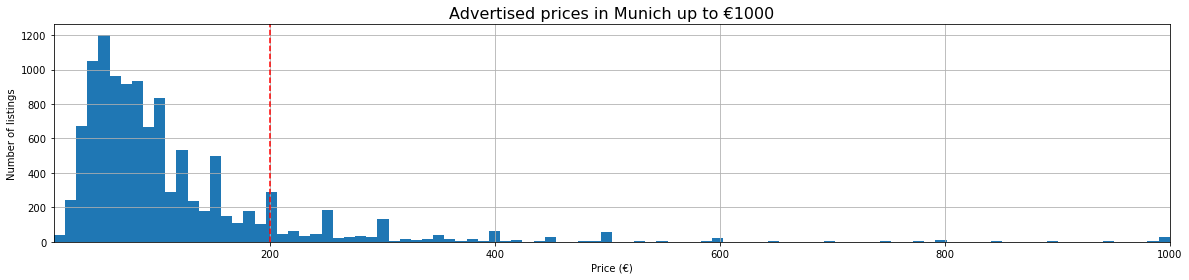

In [77]:
# Distribution of prices from €8 to €1000
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(8,1000))
plt.margins(x=0)
plt.axvline(200, color='red', linestyle='--')
plt.title("Advertised prices in Munich up to €1000", fontsize=16)
plt.xlabel("Price (€)")
plt.ylabel("Number of listings")
plt.show()

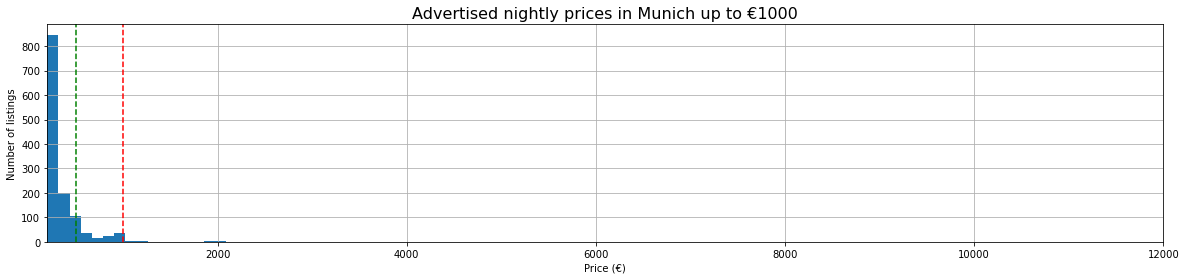

In [78]:
# Distribution of prices from €200 upwards
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(200, max(df.price)))
plt.margins(x=0)
plt.axvline(500, color='green', linestyle='--')
plt.axvline(1000, color='red', linestyle='--')
plt.title("Advertised nightly prices in Munich up to €1000", fontsize=16)
plt.xlabel("Price (€)")
plt.ylabel("Number of listings")
plt.show()


In [79]:
# Replacing values under €10 with €10
df.loc[df.price <= 10, 'price'] = 10

# Replacing values over €1000 with €1000
df.loc[df.price >= 1000, 'price'] = 1000


*host_listings_count*

The median number of listings that the host of each listing has is 1. This means that on average (median) each listing is hosted by a host who only manages that listing. The mean is slightly higher (2) due to some hosts managing larger numbers of listings, as discussed above in the Time Series section. For example, the host with the highest number of listings has 666 listings under its ID. About half of listings are from hosts with one listing, and half are from multi-listing hosts.

Two difficulties in discovering how many listings hosts have on average are:

- this number is only known on the level of the listing, so hosts with more listings are represented more frequently (e.g a host with 10 listings may be represented up to 10 times in the dataset)
-a host's other listings may not be in Munich, so some multi-listing hosts may appear multiple times in the dataset, and others may appear only once

In [80]:
print("Median number of listings per host:", int(df.host_listings_count.median()))
print("Mean number of listings per host:", int(round(df.host_listings_count.mean())))
print(f"{int(round(100*len(df[df.host_listings_count == 1])/len(df)))}% of listings are from hosts with one listing.")

Median number of listings per host: 1
Mean number of listings per host: 2
62% of listings are from hosts with one listing.


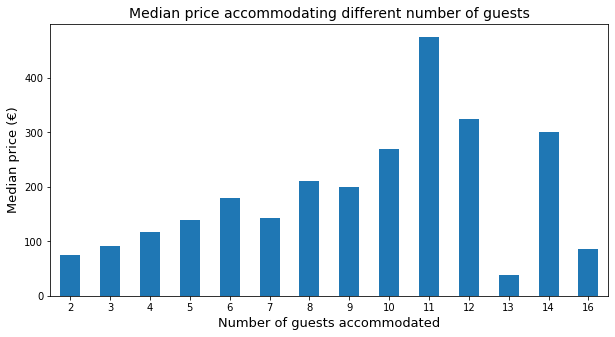

In [81]:
plt.figure(figsize=(10,5))
df.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price (€)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()


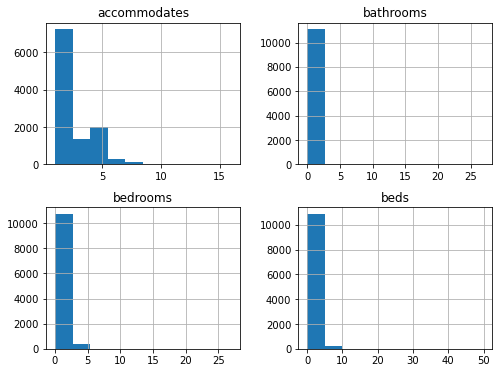

In [82]:
df[['accommodates', 'bathrooms', 'bedrooms', 'beds']].hist(figsize=(8,6));

**Categorical Features**

Categorical features will be explored and plotted, to gain insights and to determine whether or not they should be included in the final model.

*Neighbourhood*

Much of Airbnb listings are centred around Munich's Centre (Altstadt, Maxvorstadt), which is consistent with huge draw for tourists throughout the year.

In [83]:
# Renaming the neighbourhood column
df.rename(columns={'neighbourhood_cleansed': 'borough'}, inplace=True)

# Importing the Munich borough boundary GeoJSON file as a dataframe in geopandas
map_df = gpd.read_file('neighbourhoods.geojson')
map_df.head()

neighbourhood neighbourhood_group  \
0                Altstadt-Lehel                None   
1  Ludwigsvorstadt-Isarvorstadt                None   
2                   Maxvorstadt                None   
3                Schwabing-West                None   
4                 Au-Haidhausen                None   

                                            geometry  
0  MULTIPOLYGON (((11.59520 48.14170, 11.59500 48...  
1  MULTIPOLYGON (((11.55600 48.14080, 11.55930 48...  
2  MULTIPOLYGON (((11.58430 48.14420, 11.58310 48...  
3  MULTIPOLYGON (((11.58170 48.17630, 11.58320 48...  
4  MULTIPOLYGON (((11.59560 48.14050, 11.59590 48...

In [84]:
# Drop the empty column
map_df.drop('neighbourhood_group', axis=1, inplace=True)

# Create a dataframe of listing counts and median price by borough
borough_df = pd.DataFrame(df.groupby('borough').size())
borough_df.rename(columns={0: 'number_of_listings'}, inplace=True)
borough_df['median_price'] = df.groupby('borough').price.median().values

# Joining the dataframes
borough_map_df = map_df.set_index('neighbourhood').join(borough_df)

borough_map_df.head()

geometry  \
neighbourhood                                                                     
Altstadt-Lehel                MULTIPOLYGON (((11.59520 48.14170, 11.59500 48...   
Ludwigsvorstadt-Isarvorstadt  MULTIPOLYGON (((11.55600 48.14080, 11.55930 48...   
Maxvorstadt                   MULTIPOLYGON (((11.58430 48.14420, 11.58310 48...   
Schwabing-West                MULTIPOLYGON (((11.58170 48.17630, 11.58320 48...   
Au-Haidhausen                 MULTIPOLYGON (((11.59560 48.14050, 11.59590 48...   

                              number_of_listings  median_price  
neighbourhood                                                   
Altstadt-Lehel                               386         120.0  
Ludwigsvorstadt-Isarvorstadt                1215          99.0  
Maxvorstadt                                 1078          89.0  
Schwabing-West                               828          80.0  
Au-Haidhausen                                715          80.0

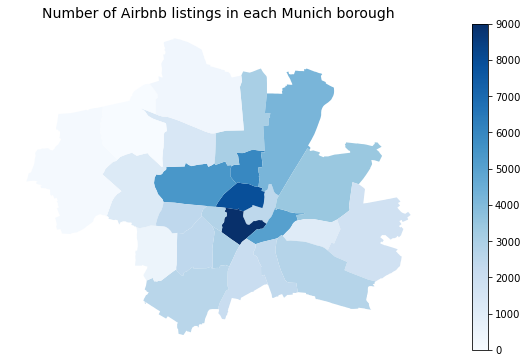

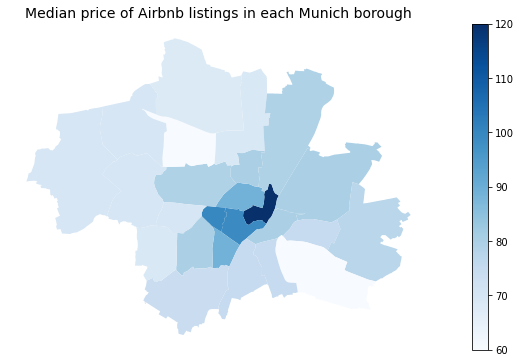

In [85]:
# Plot the number of listings in each borough
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='number_of_listings', cmap='Blues', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each Munich borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plot the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='median_price', cmap='Blues', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each Munich borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min(borough_map_df.median_price), vmax=max(borough_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

*property_type* and *room_type*

About 90% of properties are apartments/flats. The remainder are houses or more uncommon property types (e.g. bed and breakfast).

About 55% of listings are entire homes (i.e. you are renting the entire property on your own). Most of the remainder are private rooms (i.e. you are renting a bedroom and possibly also a bathroom, but there will be other people in the property). Fewer than 1% are shared rooms (i.e. you are sharing a room with either the property owner or other guests).

In [86]:
def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

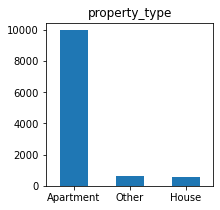

Apartment    0.894884
Other        0.054581
House        0.050535
Name: property_type, dtype: float64


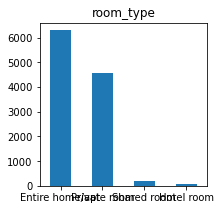

Entire home/apt    0.565147
Private room       0.411833
Shared room        0.016096
Hotel room         0.006924
Name: room_type, dtype: float64


In [87]:
for col in ['property_type', 'room_type']:
    category_count_plot(col, figsize=(3,3))
    print(df[col].value_counts(normalize=True))

*review categories*

For every review category, the majority of listings that have had a review have received a 10/10 rating for that category (or 95-100/100 overall). Ratings of 8 or below are rare. Guests seem to be most positive about communication, check-ins and accuracy. As noted previously, over a quarter of listings have not yet been reviewed.

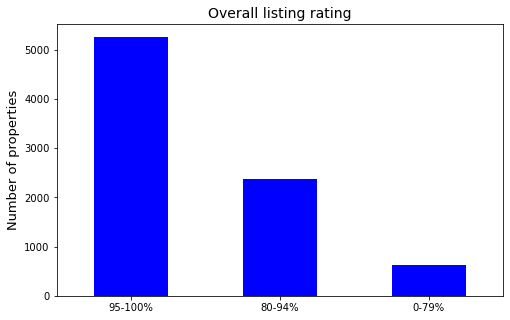

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.set_title('Overall listing rating', fontsize=14)
df['review_scores_rating'].value_counts().sort_index(ascending=False).plot(kind='bar', color=['blue'], ax=ax)
ax.set_xticklabels(labels=['95-100%', '80-94%', '0-79%'], rotation=0)
ax.set_xlabel('')
ax.set_ylabel('Number of properties', fontsize=13)
plt.show()

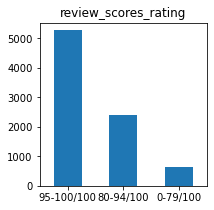

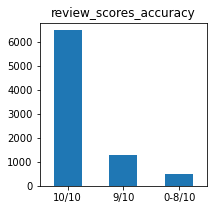

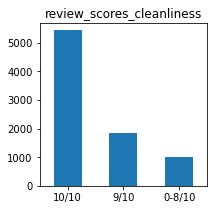

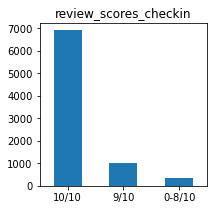

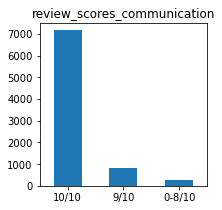

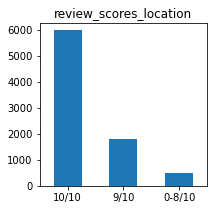

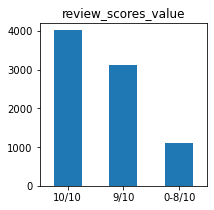

In [89]:
for col in list(df.columns[df.columns.str.startswith("review_scores") == True]):
    category_count_plot(col, figsize=(3,3))

*first_review* and *last_review*

The most common time period in which current Airbnb listings had their first review is 2-3 years. This means that a lot of listings on the site have been active for at least a couple of years. However, relatively few have been active for more than four years.

The most common category for the time since a listing received its last review is 1+ years. This means that a lot of listings have not been reviewed recently. The majority of these are probably what are sometimes referred to 'inactive' listings, because although they are technically live on the site, they do not have their calendards open and are not available to book.

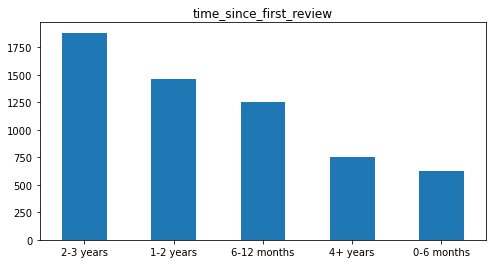

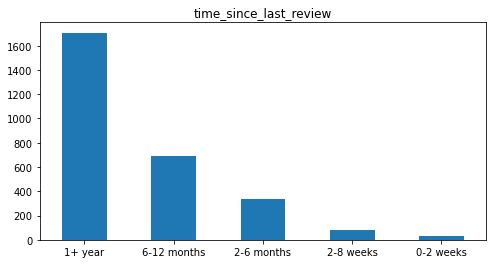

In [90]:
for col in ['time_since_first_review', 'time_since_last_review']:
    category_count_plot(col)

**Venue proximity**

We are looking to explore proximity to certain venues as a possible price predictor. Walkability and ability to reach places may be a deal-maker or breaker when it comes to choosing a accomodation. Proximity to certain venues, such as touristic attractions, restaurants, cafes and even shops could help us predict price. For this, we will use __*Foursquare API*__ to explore the venues per neighbourhood. As discussed before, *Altstadt* is the area which concentrates the majority of Airbnb listings.

We now retrieve the list of venues with their locations. We will use __*Foursquare API*__ to explore the venues around the listings, using the latitude and longitude of each neighbourhood. We will then find out which venues are the most common and select the most common venues as points of interest (*POI*s) for our accessibility analysis.

**Define Foursquare Credentials and Version**

In [ ]:
CLIENT_ID = #Your Foursquare ID 
CLIENT_SECRET = #Your Foursquare Secret
VERSION = '20180604'
LIMIT = 500
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Get the neighbourhood's names and shape

In [92]:
map_df["longitude"] = map_df.centroid.x
map_df["latitude"] = map_df.centroid.y

In [93]:
map_df.loc[:, ~map_df.columns.str.contains('^Unnamed')]
print(map_df.shape)
map_df

(25, 4)


neighbourhood  \
0                                      Altstadt-Lehel   
1                        Ludwigsvorstadt-Isarvorstadt   
2                                         Maxvorstadt   
3                                      Schwabing-West   
4                                       Au-Haidhausen   
5                                            Sendling   
6                                   Sendling-Westpark   
7                                    Schwanthalerhöhe   
8                               Neuhausen-Nymphenburg   
9                                             Moosach   
10                              Milbertshofen-Am Hart   
11                                 Schwabing-Freimann   
12                                        Bogenhausen   
13                                       Berg am Laim   
14                                      Tudering-Riem   
15                                 Ramersdorf-Perlach   
16                                        Obergiesing   
17                            Untergiesing-Harlaching   
18  Thalkirchen-Obersendling-Forstenried-Fürstenri...   
19                                             Hadern   
20                                 Pasing-Obermenzing   
21                         Aubing-Lochhausen-Langwied   
22                                Allach-Untermenzing   
23                             Feldmoching-Hasenbergl   
24                                               Laim   

                                             geometry  longitude   latitude  
0   MULTIPOLYGON (((11.59520 48.14170, 11.59500 48...  11.583178  48.141273  
1   MULTIPOLYGON (((11.55600 48.14080, 11.55930 48...  11.561218  48.130152  
2   MULTIPOLYGON (((11.58430 48.14420, 11.58310 48...  11.564298  48.148069  
3   MULTIPOLYGON (((11.58170 48.17630, 11.58320 48...  11.569307  48.166539  
4   MULTIPOLYGON (((11.59560 48.14050, 11.59590 48...  11.594758  48.129727  
5   MULTIPOLYGON (((11.55290 48.10600, 11.55180 48...  11.546057  48.115282  
6   MULTIPOLYGON (((11.53790 48.12650, 11.53770 48...  11.520021  48.116790  
7   MULTIPOLYGON (((11.53460 48.14250, 11.53880 48...  11.538246  48.136161  
8   MULTIPOLYGON (((11.54810 48.17080, 11.55010 48...  11.519305  48.156452  
9   MULTIPOLYGON (((11.53300 48.18870, 11.53470 48...  11.510923  48.181714  
10  MULTIPOLYGON (((11.58300 48.22760, 11.58430 48...  11.567868  48.195994  
11  MULTIPOLYGON (((11.62640 48.22880, 11.62830 48...  11.610558  48.192805  
12  MULTIPOLYGON (((11.66680 48.18240, 11.67180 48...  11.643526  48.157458  
13  MULTIPOLYGON (((11.60220 48.12390, 11.60360 48...  11.631715  48.126164  
14  MULTIPOLYGON (((11.67820 48.14440, 11.67820 48...  11.683573  48.123764  
15  MULTIPOLYGON (((11.60400 48.12270, 11.60610 48...  11.638702  48.099738  
16  MULTIPOLYGON (((11.60070 48.10190, 11.60420 48...  11.593269  48.102744  
17  MULTIPOLYGON (((11.58180 48.10430, 11.58190 48...  11.564134  48.098586  
18  MULTIPOLYGON (((11.54810 48.10570, 11.55110 48...  11.513238  48.086525  
19  MULTIPOLYGON (((11.47800 48.13050, 11.48300 48...  11.483451  48.113956  
20  MULTIPOLYGON (((11.46020 48.17620, 11.46460 48...  11.463274  48.152697  
21  MULTIPOLYGON (((11.43180 48.20510, 11.43250 48...  11.408340  48.164726  
22  MULTIPOLYGON (((11.48260 48.20990, 11.48280 48...  11.462006  48.192671  
23  MULTIPOLYGON (((11.50560 48.24740, 11.50620 48...  11.521979  48.215176  
24  MULTIPOLYGON (((11.51310 48.14380, 11.51900 48...  11.504656  48.136082

In [94]:
# Function to loop for venues through all neighbourhoods
#url = 'https://api.foursquare.com/v2/venues/search?categoryId=50aa9e094b90af0d42d5de0d,530e33ccbcbc57f1066bbff3,530e33ccbcbc57f1066bbff9,4f2a25ac4b909258e854f55f&intent=browse&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format()
def getNearbyVenues(names, latitudes, longitudes, radius):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&intent=browse&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
      
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        #results = requests.get(url).json()
        
         # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


Now we can run the above function on each neighborhood and create a new dataframe called **munich_venues**.

In [95]:
munich_venues = getNearbyVenues(names=map_df.neighbourhood,
                                latitudes=map_df.latitude,
                                longitudes=map_df.longitude,
                                radius = 1000
                                )
munich_venues

Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0     Altstadt-Lehel               48.141273                11.583178   
1     Altstadt-Lehel               48.141273                11.583178   
2     Altstadt-Lehel               48.141273                11.583178   
3     Altstadt-Lehel               48.141273                11.583178   
4     Altstadt-Lehel               48.141273                11.583178   
...              ...                     ...                      ...   
1223            Laim               48.136082                11.504656   
1224            Laim               48.136082                11.504656   
1225            Laim               48.136082                11.504656   
1226            Laim               48.136082                11.504656   
1227            Laim               48.136082                11.504656   

                                    Venue  Venue Latitude  Venue Longitude  \
0                         SEITZ Trattoria       48.141419        11.584902   
1                      Liebighof im Lehel       48.141640        11.586470   
2                               Hofgarten       48.143053        11.579955   
3       Hotel Vier Jahreszeiten Kempinski       48.138918        11.581775   
4                                 Brenner       48.139555        11.580924   
...                                   ...             ...              ...   
1223                         Lotto Bayern       48.129193        11.498544   
1224                            REWE CITY       48.129090        11.511068   
1225      Spezialitätenbäckerei H. Bonert       48.141912        11.495956   
1226          Ristorante Pizzeria Firenze       48.127707        11.503003   
1227  Braufässchen Customized Drinks GmbH       48.143800        11.498316   

         Venue Category  
0     Trattoria/Osteria  
1     German Restaurant  
2                Garden  
3                 Hotel  
4            Steakhouse  
...                 ...  
1223   Lottery Retailer  
1224        Supermarket  
1225             Bakery  
1226        Pizza Place  
1227            Brewery  

[1228 rows x 7 columns]

In [96]:
# Save the Dataset
munich_venues.to_csv('Munich_Venues.csv')

In [97]:
# Read dataset
munich_venues = pd.read_csv('Munich_Venues.csv', index_col=0)
print(munich_venues.shape)
munich_venues.head()

(1228, 7)


Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0  Altstadt-Lehel               48.141273                11.583178   
1  Altstadt-Lehel               48.141273                11.583178   
2  Altstadt-Lehel               48.141273                11.583178   
3  Altstadt-Lehel               48.141273                11.583178   
4  Altstadt-Lehel               48.141273                11.583178   

                               Venue  Venue Latitude  Venue Longitude  \
0                    SEITZ Trattoria       48.141419        11.584902   
1                 Liebighof im Lehel       48.141640        11.586470   
2                          Hofgarten       48.143053        11.579955   
3  Hotel Vier Jahreszeiten Kempinski       48.138918        11.581775   
4                            Brenner       48.139555        11.580924   

      Venue Category  
0  Trattoria/Osteria  
1  German Restaurant  
2             Garden  
3              Hotel  
4         Steakhouse

__*Unique categories of venues*__

In [98]:
print('There are {} uniques categories.'.format(len(munich_venues.Venue.unique())))

There are 1090 uniques categories.


__*Number of venues per category*__

In [99]:
munich_venues.groupby('Venue Category').count()

Neighbourhood  Neighbourhood Latitude  \
Venue Category                                               
Afghan Restaurant                4                       4   
African Restaurant               1                       1   
American Restaurant              4                       4   
Aquarium                         1                       1   
Arcade                           1                       1   
...                            ...                     ...   
Wine Shop                        4                       4   
Xinjiang Restaurant              1                       1   
Yoga Studio                      1                       1   
Zoo                              1                       1   
Zoo Exhibit                     12                      12   

                     Neighbourhood Longitude  Venue  Venue Latitude  \
Venue Category                                                        
Afghan Restaurant                          4      4               4   
African Restaurant                         1      1               1   
American Restaurant                        4      4               4   
Aquarium                                   1      1               1   
Arcade                                     1      1               1   
...                                      ...    ...             ...   
Wine Shop                                  4      4               4   
Xinjiang Restaurant                        1      1               1   
Yoga Studio                                1      1               1   
Zoo                                        1      1               1   
Zoo Exhibit                               12     12              12   

                     Venue Longitude  
Venue Category                        
Afghan Restaurant                  4  
African Restaurant                 1  
American Restaurant                4  
Aquarium                           1  
Arcade                             1  
...                              ...  
Wine Shop                          4  
Xinjiang Restaurant                1  
Yoga Studio                        1  
Zoo                                1  
Zoo Exhibit                       12  

[213 rows x 6 columns]

__*Analysis per neighbourhood*__

In [100]:
# One-Hot Encoding
munich_onehot = pd.get_dummies(munich_venues[['Venue Category']], prefix = "", prefix_sep = "")

# Add neighbourhood column back to df
munich_onehot['Neighbourhood'] = munich_venues['Neighbourhood']

# Move neighbourhood column to the first column
fixed_columns = [munich_onehot.columns[-1]] + list(munich_onehot.columns[:-1])
munich_onehot = munich_onehot[fixed_columns]

munich_onehot.head()

Neighbourhood  Afghan Restaurant  African Restaurant  American Restaurant  \
0  Altstadt-Lehel                  0                   0                    0   
1  Altstadt-Lehel                  0                   0                    0   
2  Altstadt-Lehel                  0                   0                    0   
3  Altstadt-Lehel                  0                   0                    0   
4  Altstadt-Lehel                  0                   0                    0   

   Aquarium  Arcade  Art Gallery  Art Museum  Asian Restaurant  \
0         0       0            0           0                 0   
1         0       0            0           0                 0   
2         0       0            0           0                 0   
3         0       0            0           0                 0   
4         0       0            0           0                 0   

   Austrian Restaurant  Auto Dealership  Automotive Shop  BBQ Joint  \
0                    0                0                0          0   
1                    0                0                0          0   
2                    0                0                0          0   
3                    0                0                0          0   
4                    0                0                0          0   

   Bagel Shop  Bakery  Bank  Bar  Bathing Area  Bavarian Restaurant  Beach  \
0           0       0     0    0             0                    0      0   
1           0       0     0    0             0                    0      0   
2           0       0     0    0             0                    0      0   
3           0       0     0    0             0                    0      0   
4           0       0     0    0             0                    0      0   

   Beach Bar  Beer Bar  Beer Garden  Beer Store  Big Box Store  Bistro  \
0          0         0            0           0              0       0   
1          0         0            0           0              0       0   
2          0         0            0           0              0       0   
3          0         0            0           0              0       0   
4          0         0            0           0              0       0   

   Bookstore  Bosnian Restaurant  Botanical Garden  Boutique  Boxing Gym  \
0          0                   0                 0         0           0   
1          0                   0                 0         0           0   
2          0                   0                 0         0           0   
3          0                   0                 0         0           0   
4          0                   0                 0         0           0   

   Breakfast Spot  Brewery  Burger Joint  Bus Line  Bus Stop  Café  \
0               0        0             0         0         0     0   
1               0        0             0         0         0     0   
2               0        0             0         0         0     0   
3               0        0             0         0         0     0   
4               0        0             0         0         0     0   

   Camera Store  Canal  Candy Store  Caucasian Restaurant  Cemetery  \
0             0      0            0                     0         0   
1             0      0            0                     0         0   
2             0      0            0                     0         0   
3             0      0            0                     0         0   
4             0      0            0                     0         0   

   Chinese Restaurant  Church  Climbing Gym  Clothing Store  Cocktail Bar  \
0                   0       0             0               0             0   
1                   0       0             0               0             0   
2                   0       0             0               0             0   
3                   0       0             0               0             0   
4                   0       0             0               0             0   

   Coffee S

__*Group rows by neighbourhood and by taking the mean and the frequency of occurrence of each category*__

In [101]:
munich_grouped = munich_onehot.groupby('Neighbourhood').mean().reset_index()
munich_grouped

Neighbourhood  Afghan Restaurant  \
0                                 Allach-Untermenzing           0.000000   
1                                      Altstadt-Lehel           0.000000   
2                                       Au-Haidhausen           0.020000   
3                          Aubing-Lochhausen-Langwied           0.000000   
4                                        Berg am Laim           0.000000   
5                                         Bogenhausen           0.000000   
6                              Feldmoching-Hasenbergl           0.000000   
7                                              Hadern           0.000000   
8                                                Laim           0.000000   
9                        Ludwigsvorstadt-Isarvorstadt           0.000000   
10                                        Maxvorstadt           0.010000   
11                              Milbertshofen-Am Hart           0.000000   
12                                            Moosach           0.000000   
13                              Neuhausen-Nymphenburg           0.000000   
14                                        Obergiesing           0.000000   
15                                 Pasing-Obermenzing           0.000000   
16                                 Ramersdorf-Perlach           0.000000   
17                                 Schwabing-Freimann           0.000000   
18                                     Schwabing-West           0.022727   
19                                   Schwanthalerhöhe           0.000000   
20                                           Sendling           0.000000   
21                                  Sendling-Westpark           0.000000   
22  Thalkirchen-Obersendling-Forstenried-Fürstenri...           0.000000   
23                                      Tudering-Riem           0.000000   
24                            Untergiesing-Harlaching           0.000000   

    African Restaurant  American Restaurant  Aquarium  Arcade  Art Gallery  \
0                 0.00             0.000000  0.000000    0.00         0.00   
1                 0.00             0.000000  0.000000    0.00         0.01   
2                 0.00             0.000000  0.000000    0.00         0.01   
3                 0.00             0.000000  0.000000    0.00         0.00   
4                 0.00             0.000000  0.000000    0.00         0.00   
5                 0.00             0.000000  0.000000    0.00         0.00   
6                 0.00             0.000000  0.000000    0.00         0.00   
7                 0.00             0.000000  0.000000    0.00         0.00   
8                 0.00             0.017857  0.000000    0.00         0.00   
9                 0.01             0.010000  0.000000    0.00         0.01   
10                0.00             0.000000  0.000000    0.01         0.00   
11                0.00             0.000000  0.000000    0.00         0.00   
12                0.00             0.027027  0.000000    0.00         0.00   
13                0.00             0.000000  0.000000    0.00         0.00   
14                0.00             0.000000  0.000000    0.00         0.00   
15                0.00             0.000000  0.000000    0.00         0.00   
16                0.00             0.000000  0.000000    0.00         0.00   
17                0.00             0.000000  0.000000    0.00         0.00   
18                0.00             0.000000  0.000000    0.00         0.00   
19                0.00             0.010000  0.000000    0.00         0.01   
20                0.00             0.000000  0.000000    0.00         0.00   
21                0.00             0.000000  0.000000    0.00         0.00   
22                0.00             0.000000  0.000000    0.00         0.00   
23                0.00             0.000000  0.000000    0.00         0.00   
24                0.00             0.000000  0.025641    0.00         0.00   

    Art Museum  Asian Restaurant  

__*Get each neighbourhood along with its top 5 most common venues*__

In [102]:
num_top_venues = 5

for hood in munich_grouped['Neighbourhood']:
    temp = munich_grouped[munich_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
   

               venue  freq
0        Zoo Exhibit  0.31
1             Bakery  0.05
2  German Restaurant  0.05
3        Supermarket  0.05
4       Soccer Field  0.05


__*Put that in pandas dataframe*__

In [103]:
# Function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [104]:
import numpy as np

# Order new Dataframe
indicators = ['st', 'nd', 'rd']

# Create columns for the number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = munich_grouped['Neighbourhood']

for ind in np.arange(munich_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(munich_grouped.iloc[ind, :], 
                                                                          num_top_venues)

neighbourhoods_venues_sorted

Neighbourhood 1st Most Common Venue  \
0                                 Allach-Untermenzing     Trattoria/Osteria   
1                                      Altstadt-Lehel                 Plaza   
2                                       Au-Haidhausen    Italian Restaurant   
3                          Aubing-Lochhausen-Langwied                Bakery   
4                                        Berg am Laim           Supermarket   
5                                         Bogenhausen              Bus Stop   
6                              Feldmoching-Hasenbergl     German Restaurant   
7                                              Hadern              Bus Stop   
8                                                Laim           Supermarket   
9                        Ludwigsvorstadt-Isarvorstadt                  Café   
10                                        Maxvorstadt                  Café   
11                              Milbertshofen-Am Hart           Supermarket   
12                                            Moosach           Supermarket   
13                              Neuhausen-Nymphenburg    Italian Restaurant   
14                                        Obergiesing              Bus Stop   
15                                 Pasing-Obermenzing                Bakery   
16                                 Ramersdorf-Perlach           Supermarket   
17                                 Schwabing-Freimann  Fast Food Restaurant   
18                                     Schwabing-West                  Park   
19                                   Schwanthalerhöhe                 Hotel   
20                                           Sendling    Italian Restaurant   
21                                  Sendling-Westpark             Drugstore   
22  Thalkirchen-Obersendling-Forstenried-Fürstenri...              Bus Stop   
23                                      Tudering-Riem           Supermarket   
24                            Untergiesing-Harlaching           Zoo Exhibit   

   2nd Most Common Venue  3rd Most Common Venue 4th Most Common Venue  \
0    Bavarian Restaurant    Sporting Goods Shop                Bakery   
1                   Café      German Restaurant   Bavarian Restaurant   
2                   Café      French Restaurant                 Plaza   
3            Post Office                  Hotel                Bistro   
4           Tram Station                 Bakery              Bus Stop   
5            Supermarket     Italian Restaurant             Drugstore   
6               Bus Stop                   Café      Greek Restaurant   
7            Supermarket      German Restaurant        Sandwich Place   
8               Bus Stop                 Bakery      Greek Restaurant   
9     Italian Restaurant  Vietnamese Restaurant        Ice Cream Shop   
10    Italian Restaurant             Restaurant                 Plaza   
11       Motorcycle Shop                 Lounge          Tennis Court   
12                Bakery              Drugstore                 Hotel   
13                Bakery         Shipping Store                 Canal   
14             Drugstore            Supermarket                 Hotel   
15                  Café     Italian Restaurant             Drugstore   
16                Bakery      German Restaurant                 Hotel   
17      Greek Restaurant       Asian Restaurant          Concert Hall   
18      Greek Restaurant     Italian Restaurant     Trattoria/Osteria   
19                  Café     Italian Restaurant      Asian Restaurant   
20           Supermarket      German Restaurant                Bakery   
21      Greek Restaurant               Bus Stop                Bakery   
22           Supermarket   Gym / Fitness Center             Drugstore   
23    Italian Restaurant   Fast Food Restaurant              Bus Stop   
24          Soccer Field                   Café           Sports Club   

   5th Most Common Venue  
0              Drugstore  
1                  Hotel  
2    

__*Let's look at how many categories are on the 1st most common venue*__

In [105]:
print('There are {} unique categories.'.format(len(neighbourhoods_venues_sorted['1st Most Common Venue'].unique())))

There are 13 unique categories.


In [106]:
neighbourhoods_venues_sorted.groupby('1st Most Common Venue').count()

Neighbourhood  2nd Most Common Venue  \
1st Most Common Venue                                         
Bakery                             2                      2   
Bus Stop                           4                      4   
Café                               2                      2   
Drugstore                          1                      1   
Fast Food Restaurant               1                      1   
German Restaurant                  1                      1   
Hotel                              1                      1   
Italian Restaurant                 3                      3   
Park                               1                      1   
Plaza                              1                      1   
Supermarket                        6                      6   
Trattoria/Osteria                  1                      1   
Zoo Exhibit                        1                      1   

                       3rd Most Common Venue  4th Most Common Venue  \
1st Most Common Venue                                                 
Bakery                                     2                      2   
Bus Stop                                   4                      4   
Café                                       2                      2   
Drugstore                                  1                      1   
Fast Food Restaurant                       1                      1   
German Restaurant                          1                      1   
Hotel                                      1                      1   
Italian Restaurant                         3                      3   
Park                                       1                      1   
Plaza                                      1                      1   
Supermarket                                6                      6   
Trattoria/Osteria                          1                      1   
Zoo Exhibit                                1                      1   

                       5th Most Common Venue  
1st Most Common Venue                         
Bakery                                     2  
Bus Stop                                   4  
Café                                       2  
Drugstore                                  1  
Fast Food Restaurant                       1  
German Restaurant                          1  
Hotel                                      1  
Italian Restaurant                         3  
Park                                       1  
Plaza                                      1  
Supermarket                                6  
Trattoria/Osteria                          1  
Zoo Exhibit                                1

As we can observe from above, the most common Venues are *Bakeries*, *Supermarkets* and *Bus Stops* followed by *Cafés* and different *Restaurants*.

**Walkability to nearest venues**

We will use this information on venues to select *Points of Interest* for which we will graph and measure access to each one. For this purpose, we will use OSMnx and Pandana libraries.

Pandana is a handy graph library that allows for Pandas data frames to be passed through into a network graph that maps graph-level analyses to underlying C operations. All of this is to say, it's much faster than traditional Python-based graphs, such as NetworkX.

In certain situations, such as the performance of accessibility analyses, this makes in-memory performance and iterative development based on this library possible, as opposed to what would be a cumbersome development process with tools that fail to leverage the same degree of C-level operations utilization.

__*Points of interest (POIs) and network data from OSM*__

We will now get the points of interest. For our case, we already have the POIs retrieved using the Foursquare API. As we found out in the previous section, *Cafés*, *Plaza*, *Beer Garden*, *Restaurants* and *Garden* are our POIs.

In [107]:
# same with Munich_Venues
munich_venues['Venue Category'].value_counts()

Supermarket           63
Café                  62
Italian Restaurant    60
German Restaurant     53
Bakery                53
                      ..
Event Space            1
Sausage Shop           1
Bagel Shop             1
Diner                  1
Arcade                 1
Name: Venue Category, Length: 213, dtype: int64

In [108]:
# Get just Restaurant, Plaza, Café, Beer Garden and Garden
start_time = time.time()

# Load POIs from munich_venues
df_pois = munich_venues.copy()
terms = ['Restaurant', 'Plaza', 'Café', 'Beer Garden', 'Garden']
df_pois = df_pois[df_pois['Venue Category'].str.contains('|'.join(terms))]
df_pois.to_csv('foursquare_amenities.csv', index=id, header=True)
method = 'loaded from CSV'
print('{:,} POIs {} in {:,.2f} seconds'.format(len(df_pois), method, time.time()-start_time))
df_pois.head()

458 POIs loaded from CSV in 0.05 seconds


Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
1   Altstadt-Lehel               48.141273                11.583178   
2   Altstadt-Lehel               48.141273                11.583178   
6   Altstadt-Lehel               48.141273                11.583178   
9   Altstadt-Lehel               48.141273                11.583178   
12  Altstadt-Lehel               48.141273                11.583178   

                 Venue  Venue Latitude  Venue Longitude  \
1   Liebighof im Lehel       48.141640        11.586470   
2            Hofgarten       48.143053        11.579955   
6     The spice bazaar       48.140696        11.581910   
9        Marstallplatz       48.140260        11.581016   
12           La Stanza       48.139830        11.586984   

              Venue Category  
1          German Restaurant  
2                     Garden  
6   Mediterranean Restaurant  
9                      Plaza  
12        Italian Restaurant

In [109]:
# Does each variable's type makes sense?
df_pois.dtypes

Neighbourhood               object
Neighbourhood Latitude     float64
Neighbourhood Longitude    float64
Venue                       object
Venue Latitude             float64
Venue Longitude            float64
Venue Category              object
dtype: object

In [110]:
# Number of POIs of each type of amenity we retrieve
df_pois['Venue Category'].value_counts()

Café                             62
Italian Restaurant               60
German Restaurant                53
Plaza                            34
Asian Restaurant                 21
Restaurant                       19
Greek Restaurant                 19
Bavarian Restaurant              16
Vietnamese Restaurant            15
Doner Restaurant                 15
French Restaurant                11
Indian Restaurant                11
Sushi Restaurant                  9
Fast Food Restaurant              9
Beer Garden                       8
Japanese Restaurant               7
Thai Restaurant                   7
Chinese Restaurant                6
Seafood Restaurant                5
Middle Eastern Restaurant         5
Mexican Restaurant                5
Falafel Restaurant                4
American Restaurant               4
Spanish Restaurant                4
Afghan Restaurant                 4
Turkish Restaurant                4
Modern European Restaurant        3
Mediterranean Restaurant    

In [111]:
# Put all restaurant, bar and pub venues together under same name
df_pois.loc[df_pois['Venue Category'].str.contains('Restaurant', case=False), 'Venue Category'] = 'Restaurant'
df_pois.loc[df_pois['Venue Category'].str.contains('Bar', case=False), 'Venue Category'] = 'Bar'
df_pois.loc[df_pois['Venue Category'].str.contains('Pub', case=False), 'Venue Category'] = 'Pub'
df_pois['Venue Category'].value_counts()

Restaurant          347
Café                 62
Plaza                34
Beer Garden           8
Garden                3
Garden Center         2
Shopping Plaza        1
Botanical Garden      1
Name: Venue Category, dtype: int64

*Next we get the street network data from the OpenStreetMap API*

In [112]:
# Package needed for getting the street network
!{sys.executable} -m pip install osmnet

In [113]:
import osmnet

In [114]:
# configure filenames to save/load network datasets
# Munich's bounding box is found here: https://boundingbox.klokantech.com/
bbox = (48.030794,11.387478,48.242663,11.761013) 
bbox_string = '_'.join([str(x) for x in bbox])
net_filename = 'data_{}.h5'.format(bbox_string)

In [115]:
start_time = time.time()

# query the OSM API for the street network within the specified bounding box
network = osm.pdna_network_from_bbox(bbox[0], bbox[1], bbox[2], bbox[3])
method = 'downloaded from OSM'
print(type(network))

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](48.03079400,11.38747800,48.24266300,11.76101300);>;);out;'}"
Downloaded 77,551.9KB from www.overpass-api.de in 5.39 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 10.27 seconds
Returning OSM data with 473,753 nodes and 139,059 ways...
Edge node pairs completed. Took 532.76 seconds
Returning processed graph with 181,930 nodes and 255,170 edges...
Completed OSM data download and Pandana node and edge table creation in 568.37 seconds
<class 'pandana.network.Network'>


In [116]:
# identify nodes that are connected to fewer than some threshold of other nodes within a given distance
lcn = network.low_connectivity_nodes(impedance=1000, count=10, imp_name='distance')

# remove low-connectivity nodes and save to h5
network.save_hdf5('mynetwork.h5',rm_nodes=lcn)

In [117]:
print('Network with {:,} nodes {} in {:,.2f} secs'.format(len(network.node_ids), method, time.time()-start_time))

Network with 181,930 nodes downloaded from OSM in 839.82 secs


When saving a Network to a HDF5 file, it’s possible to exclude certain nodes. This can be useful when refining a network so that it includes only validated nodes. As an example, you can use the *low_connectivity_nodes()* method to identify nodes that may not be connected to the larger network, then exclude those nodes when saving to HDF5. In the current design of Pandana it’s not possible to modify a Network in place. Instead, save the network (with low-connectivity nodes removed) to HDF5 and then load it from that file by re-starting the notebook.

__*Calculate accessibility to any amenity we retrieved*__

This is where conducting geographical analysis in Python shows its power, as opposed to sitting in front of a *GIS* package. Pandana is built for speed. First, we'll pass it a maximum search distance. This allows a key step that speeds up future enquiries: Pandana will build a condensed representation of the network (implemented in C++), allowing rapid calculations within a defined radius of each node. We then, build a table of distances to the nearest 5 points of interest from a couple of intersections. When this is finished, accessibility analyses for different selected amenities can be done in under a second. (Behind the scenes, two algorithms make this possible: [*contraction hierarchies*](https://www.mjt.me.uk/posts/contraction-hierarchies/) and [*kd-trees*](https://www.geeksforgeeks.org/k-dimensional-tree/).

This section of the notebook is heavily based on Professor Geoff Boeing's [Pandana demo notebook](https://nbviewer.jupyter.org/github/gboeing/urban-data-science/blob/master/20-Accessibility-Walkability/pandana-accessibility-demo-full.ipynb).

In [118]:
# configure search at a max distance of 1km for up to the 10 nearest points-of-interest
distance = 1000
num_pois = 10
num_categories = len(df_pois['Venue']) + 1 #one for each amenity, plus one extra for all of them combined

In [119]:
## precomputes the range queries (the reachable nodes within this maximum distance)
# so, as long as you use a smaller distance, cached results will be used
network.precompute(distance + 1)

In [120]:
# initialize the underlying C++ points-of-interest engine
network.init_pois(num_categories=num_categories, max_dist=distance, max_pois=num_pois)

In [121]:
# initialize a category for all amenities with the locations specified by the lon and lat columns
# with Munich_Venues subset df_pois
network.set_pois(category='all', x_col = df_pois['Venue Longitude'], y_col = df_pois['Venue Latitude'])

Reading parameters from init_pois()
Reading parameters from init_pois()


In [122]:
# searches for the n-nearest amenities (of all types) to each node in the network
all_access = network.nearest_pois(distance=distance, category='all', num_pois=num_pois)

# it returns a df with the number of columns equal to the number of POIs that are requested
# each cell represents the network distance from the node to each of the n POIs
print('{:,} nodes'.format(len(all_access)))
all_access.head() # Distance in meters to ten nearest amenities

181,930 nodes


1       2       3       4       5       6       7       8   \
id                                                                       
128233  1000.0  1000.0  1000.0  1000.0  1000.0  1000.0  1000.0  1000.0   
128234  1000.0  1000.0  1000.0  1000.0  1000.0  1000.0  1000.0  1000.0   
128236  1000.0  1000.0  1000.0  1000.0  1000.0  1000.0  1000.0  1000.0   
128238  1000.0  1000.0  1000.0  1000.0  1000.0  1000.0  1000.0  1000.0   
128239  1000.0  1000.0  1000.0  1000.0  1000.0  1000.0  1000.0  1000.0   

            9       10  
id                      
128233  1000.0  1000.0  
128234  1000.0  1000.0  
128236  1000.0  1000.0  
128238  1000.0  1000.0  
128239  1000.0  1000.0

*Produce Accessibility maps*

In [123]:
# keyword arguments to pass for the matplotlib figure
bbox_aspect_ratio = (bbox[2] - bbox[0]) / (bbox[3] - bbox[1])
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10 * bbox_aspect_ratio)}

# keyword arguments to pass for scatter plots
plot_kwargs = {'s':5, 
               'alpha':0.9, 
               'cmap':'Blues', 
               'edgecolor':'none'}

# network aggregation plots are the same as regular scatter plots, but without a reversed colormap
agg_plot_kwargs = plot_kwargs.copy()
agg_plot_kwargs['cmap'] = 'Blues'

# keyword arguments to pass for hex bin plots
hex_plot_kwargs = {'gridsize':60,
                   'alpha':0.9, 
                   'cmap':'Blues', 
                   'edgecolor':'none'}

# keyword arguments to pass to make the colorbar
cbar_kwargs = {}

# keyword arguments to pass to basemap
bmap_kwargs = {}

# color to make the background of the axis
bgcolor = 'k'

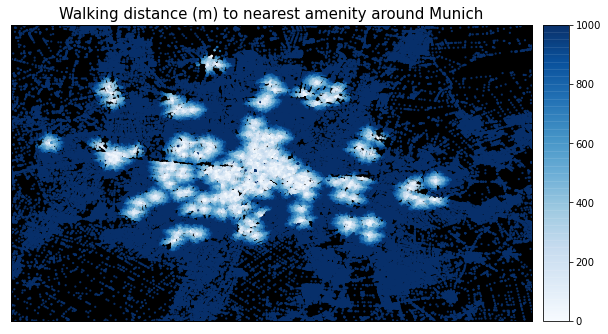

In [124]:
# distance to the nearest amenity of any type
n = 1
bmap, fig, ax = network.plot(all_access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, 
                             bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to nearest amenity around Munich', fontsize=15)
fig.savefig('Accessibility-Munich.png', dpi=300, bbox_inches='tight')



As seen above, for most of the zones people have to walk more than 500 meters to reach the nearest amenity, whereas Munich's *Altstadt* has walking distances of less than 100 meters on average.
The map shows the walking distance in meters from each network node to the nearest Café, Plaza, Beer Garden, Restaurant and Garden. 

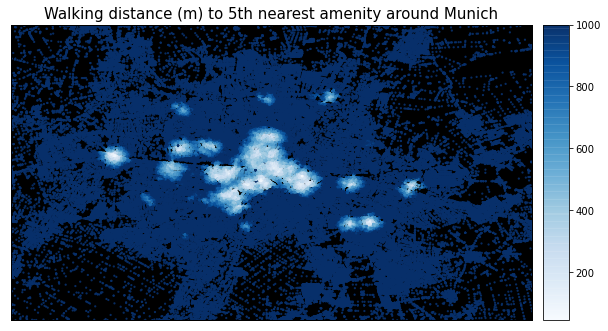

In [125]:
# distance to the 5th nearest amenity of any type
n = 5
bmap, fig, ax = network.plot(all_access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, 
                             bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to 5th nearest amenity around Munich', fontsize=15)
fig.savefig('accessibility-nearest5th-Munich.png', dpi=200, bbox_inches='tight')

It's even more noticeable this time, that Altstadt and the city center area od Munich is more accessible.

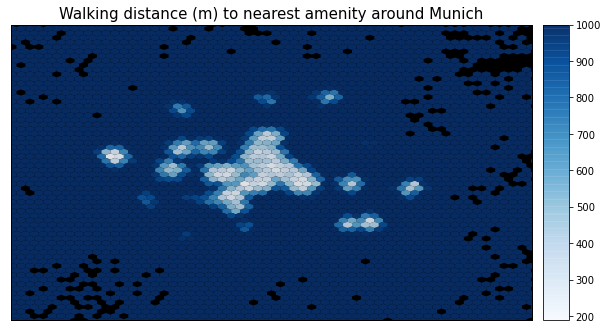

In [126]:
# distance to the 5th nearest amenity of any type, as hexbins
n=5
bmap, fig, ax = network.plot(all_access[n], bbox=bbox, plot_type='hexbin', plot_kwargs=hex_plot_kwargs, 
                             fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to nearest amenity around Munich', fontsize=15)
fig.savefig('Accessibility-hexbins-Munich.png', dpi=300, bbox_inches='tight')

*Setting distance to the fifth nearest amenity as a compound measure of accessibility*

In [127]:
# retreive the 5th nearest amenities (of all types) to each node in the network
num_pois = 5
N_nearest_access = network.nearest_pois(distance=distance, category='all', num_pois=num_pois)

# returned a df with the number of columns equal to the number of POIs that are requested
# each cell represents the network distance from the node to each of the 5 POIs
print('{:,} nodes'.format(len(N_nearest_access)))

Access_Score = pd.DataFrame(N_nearest_access[5])
Access_Score.head()

181,930 nodes


5
id            
128233  1000.0
128234  1000.0
128236  1000.0
128238  1000.0
128239  1000.0

*Network aggregation*

Here, we combine Score, our compound measure of accessibility (network distance from the node to the 5th nearest POIs) with the POIs dataset df_pois.

In [128]:
# We name our measure 'Score'
Access = Access_Score.rename(columns={5:'Score'})
Access.head()
Access.dtypes

Score    float64
dtype: object

Get the nearest node_id for each POI, based on its lat-lon

In [129]:
df_pois['node_ids'] = network.get_node_ids(df_pois['Venue Longitude'], df_pois['Venue Latitude'])
df_pois.head()

Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
1   Altstadt-Lehel               48.141273                11.583178   
2   Altstadt-Lehel               48.141273                11.583178   
6   Altstadt-Lehel               48.141273                11.583178   
9   Altstadt-Lehel               48.141273                11.583178   
12  Altstadt-Lehel               48.141273                11.583178   

                 Venue  Venue Latitude  Venue Longitude Venue Category  \
1   Liebighof im Lehel       48.141640        11.586470     Restaurant   
2            Hofgarten       48.143053        11.579955         Garden   
6     The spice bazaar       48.140696        11.581910     Restaurant   
9        Marstallplatz       48.140260        11.581016          Plaza   
12           La Stanza       48.139830        11.586984     Restaurant   

      node_ids  
1   2072498330  
2   1636729033  
6    270534572  
9    637837442  
12    32920659

In [130]:
#pois_sub.reset_index(level=0, inplace=True) # convert index into column
Access.reset_index(level=0, inplace=True)

In [131]:
# Set both columns to have the same names
Access = Access.rename(columns={'id':'node_ids'})
Access.head()

node_ids   Score
0    128233  1000.0
1    128234  1000.0
2    128236  1000.0
3    128238  1000.0
4    128239  1000.0

In [132]:
# Merging by node_ids
merged = pd.merge(df_pois, Access, on='node_ids')

In [133]:
# Checking column types make sense
merged.dtypes

Neighbourhood               object
Neighbourhood Latitude     float64
Neighbourhood Longitude    float64
Venue                       object
Venue Latitude             float64
Venue Longitude            float64
Venue Category              object
node_ids                     int64
Score                      float64
dtype: object

In [134]:
merged.head()

Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0  Altstadt-Lehel               48.141273                11.583178   
1  Altstadt-Lehel               48.141273                11.583178   
2  Altstadt-Lehel               48.141273                11.583178   
3  Altstadt-Lehel               48.141273                11.583178   
4  Altstadt-Lehel               48.141273                11.583178   

                Venue  Venue Latitude  Venue Longitude Venue Category  \
0  Liebighof im Lehel       48.141640        11.586470     Restaurant   
1           Hofgarten       48.143053        11.579955         Garden   
2    The spice bazaar       48.140696        11.581910     Restaurant   
3       Marstallplatz       48.140260        11.581016          Plaza   
4           La Stanza       48.139830        11.586984     Restaurant   

     node_ids       Score  
0  2072498330  389.472992  
1  1636729033  377.544006  
2   270534572  356.330994  
3   637837442  275.313995  
4    32920659  253.759003

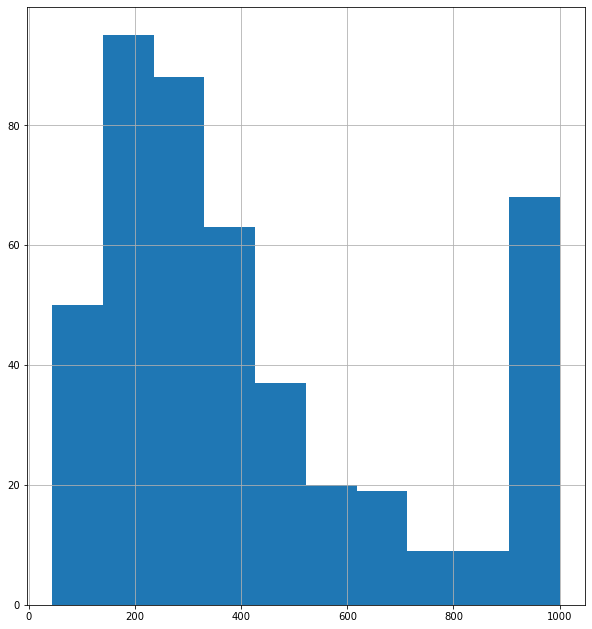

In [135]:
merged['Score'].hist(figsize=(10,11))

In [136]:
# Setting both columns to have the same name for merging
df = df.rename(columns={'borough': 'Neighbourhood'})

In [137]:
# Merging by neighbourhoods
df_merged = pd.merge(merged, df, on='Neighbourhood')

In [138]:
# Save cleaned for modelling
df_merged.to_csv('listings_model.csv', index=id, header=True)

## Preparing data for modelling

__*Dropping columns and assessing multi-collinearity*__

Categorical variables will now be one-hot encoded:
The accessibility score *Score* (distance to the nearest venue) is now applied to each listing, based on which neighbourhood they belong to. Thus, we no longer need the geographical data or the venue data.

In [139]:
# Open merged dataset for modelling
df_merged = pd.read_csv('listings_model.csv', index_col=0)
df_merged.head()

Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0  Altstadt-Lehel               48.141273                11.583178   
1  Altstadt-Lehel               48.141273                11.583178   
2  Altstadt-Lehel               48.141273                11.583178   
3  Altstadt-Lehel               48.141273                11.583178   
4  Altstadt-Lehel               48.141273                11.583178   

                Venue  Venue Latitude  Venue Longitude Venue Category  \
0  Liebighof im Lehel        48.14164         11.58647     Restaurant   
1  Liebighof im Lehel        48.14164         11.58647     Restaurant   
2  Liebighof im Lehel        48.14164         11.58647     Restaurant   
3  Liebighof im Lehel        48.14164         11.58647     Restaurant   
4  Liebighof im Lehel        48.14164         11.58647     Restaurant   

     node_ids       Score  host_response_time host_response_rate  \
0  2072498330  389.472992        within a day               100%   
1  2072498330  389.472992  within a few hours               100%   
2  2072498330  389.472992  within a few hours               100%   
3  2072498330  389.472992  within a few hours               100%   
4  2072498330  389.472992  within a few hours               100%   

   host_is_superhost  host_listings_count  host_identity_verified  \
0                0.0                  1.0                     1.0   
1                1.0                  4.0                     0.0   
2                1.0                  4.0                     0.0   
3                1.0                  4.0                     0.0   
4                1.0                  4.0                     0.0   

  property_type        room_type  accommodates  bathrooms  bedrooms  beds  \
0     Apartment  Entire home/apt             3        1.0       2.0   2.0   
1         Other       Hotel room             2        1.0       1.0   2.0   
2         Other       Hotel room             2        0.5       1.0   2.0   
3         Other       Hotel room             2        0.5       1.0   2.0   
4         Other       Hotel room             2        1.0       1.0   2.0   

   price  security_deposit  cleaning_fee  guests_included  extra_people  \
0    330               600            60                3            20   
1    180                 0             0                2             0   
2    160                 0             0                2             0   
3    160                 0             0                2            30   
4    180                 0             0                3            30   

   minimum_nights  maximum_nights  availability_90  number_of_reviews  \
0               3             365               90                 55   
1               1              28               65                  4   
2               1              28               17                 11   
3               1              28               67                184   
4               1              28               67                  2   

  review_scores_rating review_scores_accuracy review_scores_cleanliness  \
0           95-100/100                  10/10                     10/10   
1            80-94/100                  10/10                     10/10   
2           95-100/100                  10/10                     10/10   
3           95-100/100                  10/10                      9/10   
4           95-100/100                  10/10                     10/10   

  review_scores_checkin review_scores_communication review_scores_location  \
0                 10/10                       10/10                  10/10   
1                 10/10                       10/10                  10/10   
2                 10/10                       10/10                  10/10   
3                 10/10                       10/10                  10/10   
4                 10/10                       10/10                  10/10   

  review_scores_value  instant_bookable        

In [140]:
# Dropping variables no longer needed
df_merged.drop(['Neighbourhood Longitude', 'Venue Latitude', 'Venue Longitude','Neighbourhood Latitude',
               'Venue Category', 'node_ids', 'Venue'], axis=1, inplace=True)


In [141]:
# Get dummies
transformed_df = pd.get_dummies(df_merged)
transformed_df.head()

Score  host_is_superhost  host_listings_count  host_identity_verified  \
0  389.472992                0.0                  1.0                     1.0   
1  389.472992                1.0                  4.0                     0.0   
2  389.472992                1.0                  4.0                     0.0   
3  389.472992                1.0                  4.0                     0.0   
4  389.472992                1.0                  4.0                     0.0   

   accommodates  bathrooms  bedrooms  beds  price  security_deposit  \
0             3        1.0       2.0   2.0    330               600   
1             2        1.0       1.0   2.0    180                 0   
2             2        0.5       1.0   2.0    160                 0   
3             2        0.5       1.0   2.0    160                 0   
4             2        1.0       1.0   2.0    180                 0   

   cleaning_fee  guests_included  extra_people  minimum_nights  \
0            60                3            20               3   
1             0                2             0               1   
2             0                2             0               1   
3             0                2            30               1   
4             0                3            30               1   

   maximum_nights  availability_90  number_of_reviews  instant_bookable  \
0             365               90                 55                 0   
1              28               65                  4                 1   
2              28               17                 11                 1   
3              28               67                184                 1   
4              28               67                  2                 1   

   host_days_active  balcony  bed_linen   tv  coffee_machine  cooking_basics  \
0            2879.0      0.0        1.0  1.0             1.0             0.0   
1            2875.0      0.0        0.0  1.0             1.0             0.0   
2            2875.0      0.0        0.0  1.0             0.0             0.0   
3            2875.0      0.0        0.0  1.0             0.0             0.0   
4            2875.0      0.0        0.0  1.0             0.0             0.0   

   white_goods  elevator  child_friendly  parking  host_greeting  internet  \
0          1.0       1.0             0.0      0.0            0.0       1.0   
1          0.0       0.0             0.0      1.0            1.0       1.0   
2          0.0       0.0             0.0      1.0            1.0       1.0   
3          0.0       0.0             0.0      1.0            1.0       1.0   
4          0.0       0.0             0.0      1.0            1.0       1.0   

   long_term_stays  pets_allowed  private_entrance  smoking_allowed  \
0              0.0           0.0               0.0              0.0   
1              1.0           0.0               1.0              0.0   
2              1.0           0.0               0.0              0.0   
3              1.0           0.0               0.0              0.0   
4              1.0           0.0               0.0              0.0   

   Neighbourhood_Allach-Untermenzing  Neighbourhood_Altstadt-Lehel  \
0                                  0                             1   
1                                  0                             1   
2                                  0                             1   
3                                  0                             1   
4                                  0                             1   

   Neighbourhood_Au-Haidhausen  Neighbourhood_Aubing-Lochhausen-Langwied  \
0                            0                                         0   
1                            0                                         0   
2                            0                                         0   
3                            0                                         0   
4                            0                                      

*We now assess for multicollinearity of features*

In [142]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap=sns.diverging_palette(220, 10, as_cmap=True)
    
    # Draw the heatmap with the mask and correct aspect ratio
    ax=sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.5}, vmax=corr[corr != 1.0].max().max());

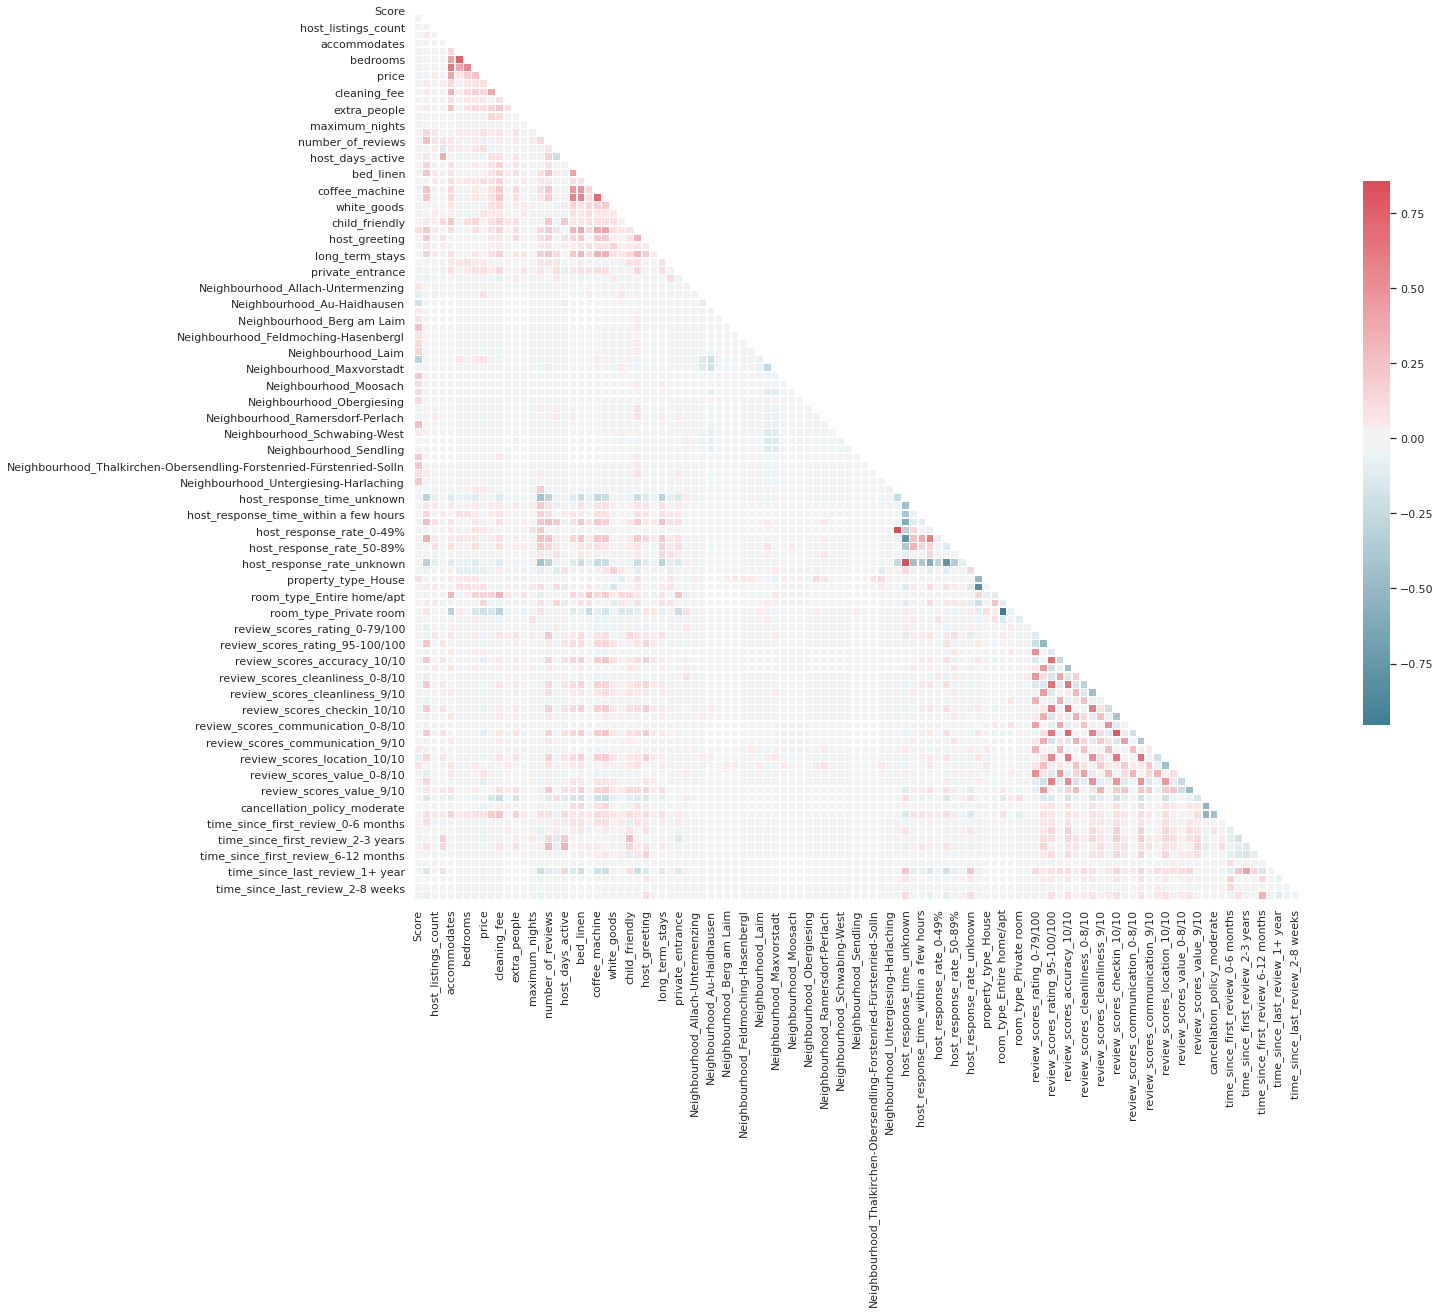

In [143]:
multi_collinearity_heatmap(transformed_df, figsize=(20, 20))

It doesn't look like there are any significant collinear relationships with neighbourhood variables, so we will temporarily drop them to produce a clearer heatmap for the remaining features:

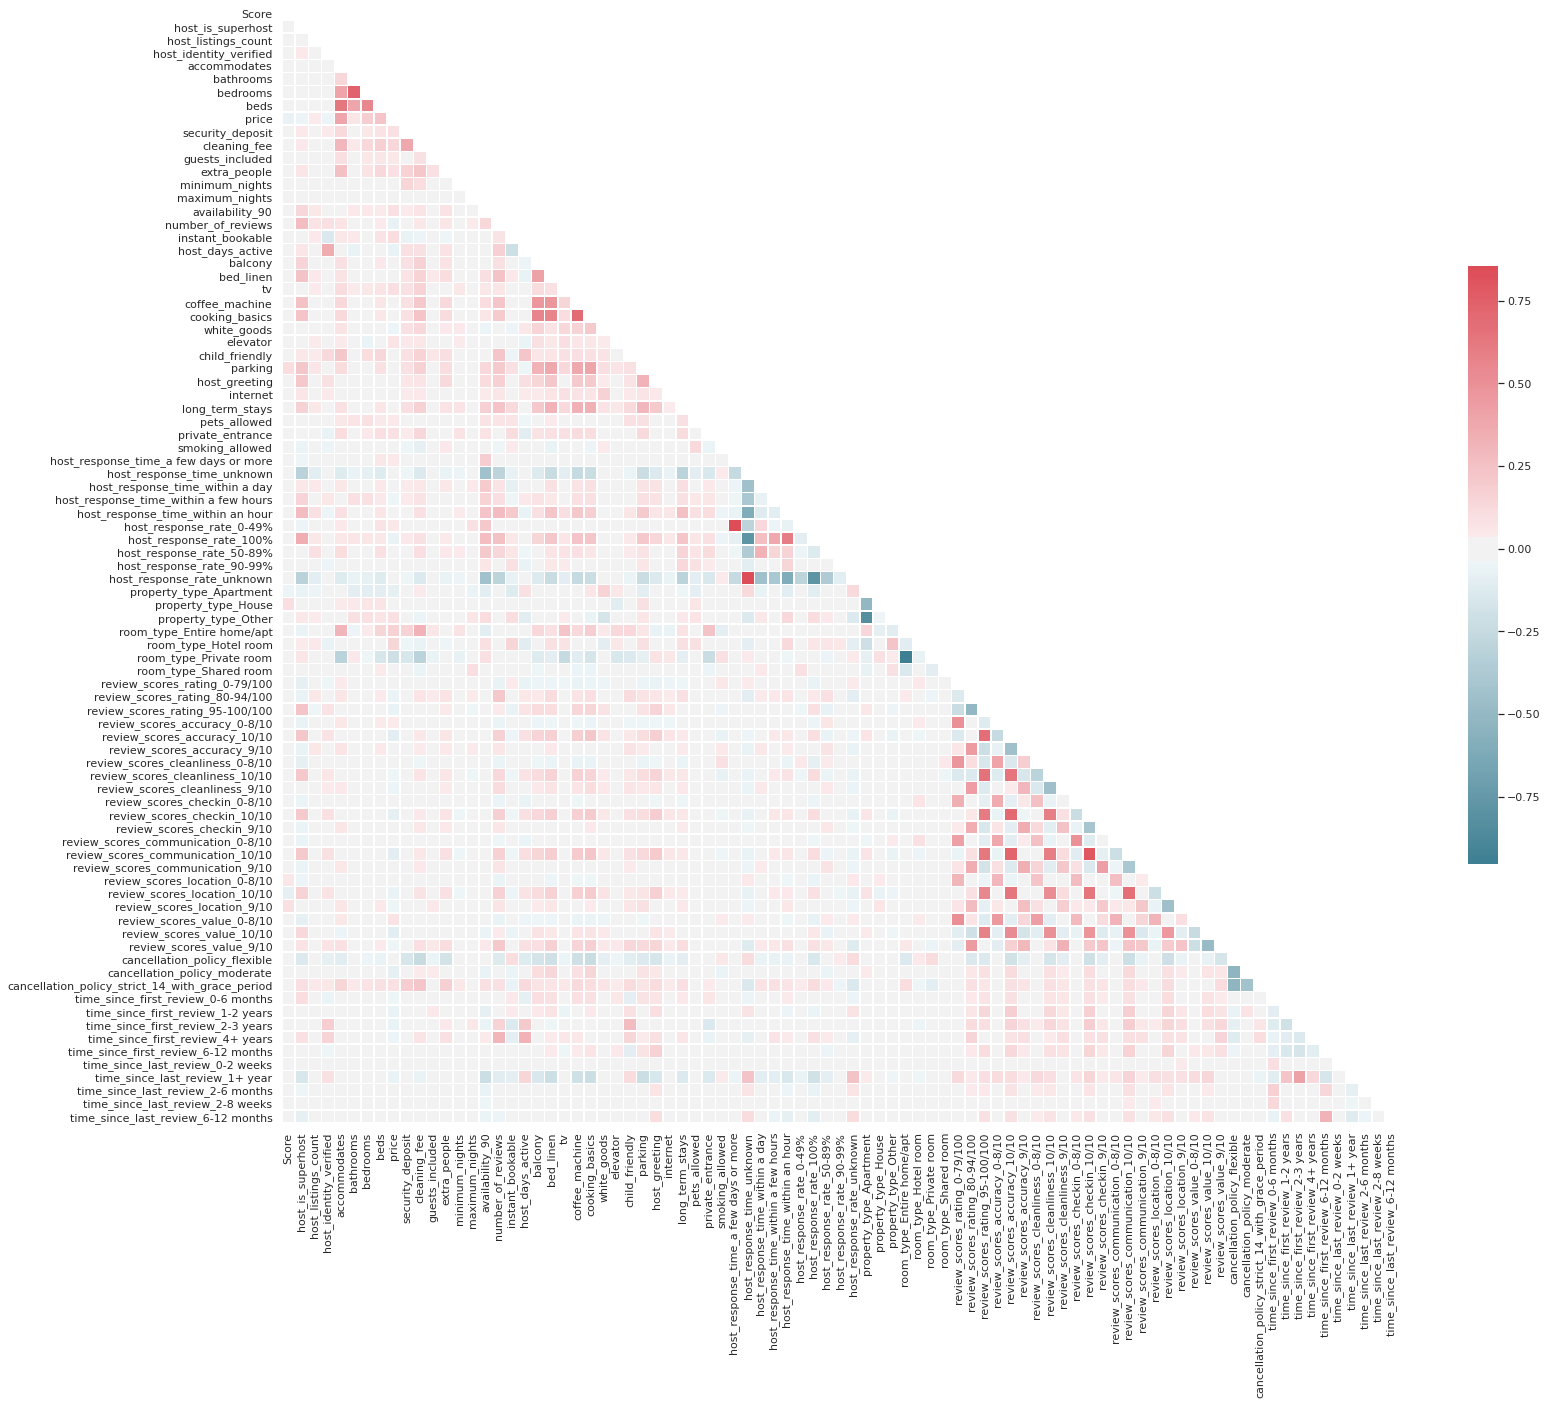

In [144]:
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('Neighbourhood')]), axis=1), figsize=(25,22))

Areas of multi-collinearity:

* *Beds*, *bedrooms*, *guests_included* and the *number of people that a property accommodates* are correlated. The number of people accommodated has traditionally been a more high priority search parameter on Airbnb, as it is more relevant for private and shared rooms than the number of bedrooms (and is still the second highest priority parameter when searching on the site, after dates.

* Unsurprisingly, there are perfect correlations between *NaN reviews* (i.e. listings that are not reviewed yet) for different review categories, and *first and last review times*. NaN categories can therefore be dropped.

* The same is true for *host_response_rate_unknown* and *host_response_time_unknown*. One of these rates will be dropped.

* There is a correlation between *host_response_rate 0-49%* and *host_response_time_a few days or more*. One of these will be dropped.

* There are strong negative correlations between *property_type_Other* and *property_type_Apartment*, and between *room_type_Private room* and *room_type_Entire_home_apt* (as these were the main two categories of their features before they were one-hot encoded). Although these are important categories, one of each will be dropped in order to reduce multi-collinearity (apartments and private rooms, as these are the second most common categories).

In [145]:
# Dropping collinear features
to_drop = ['beds',
           'bedrooms',
           'guests_included', 
           'host_response_rate_unknown',
           'host_response_rate_0-49%',
           'property_type_Other',
           'room_type_Private room']
to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('nan')]))

transformed_df.drop(to_drop, axis=1, inplace=True)

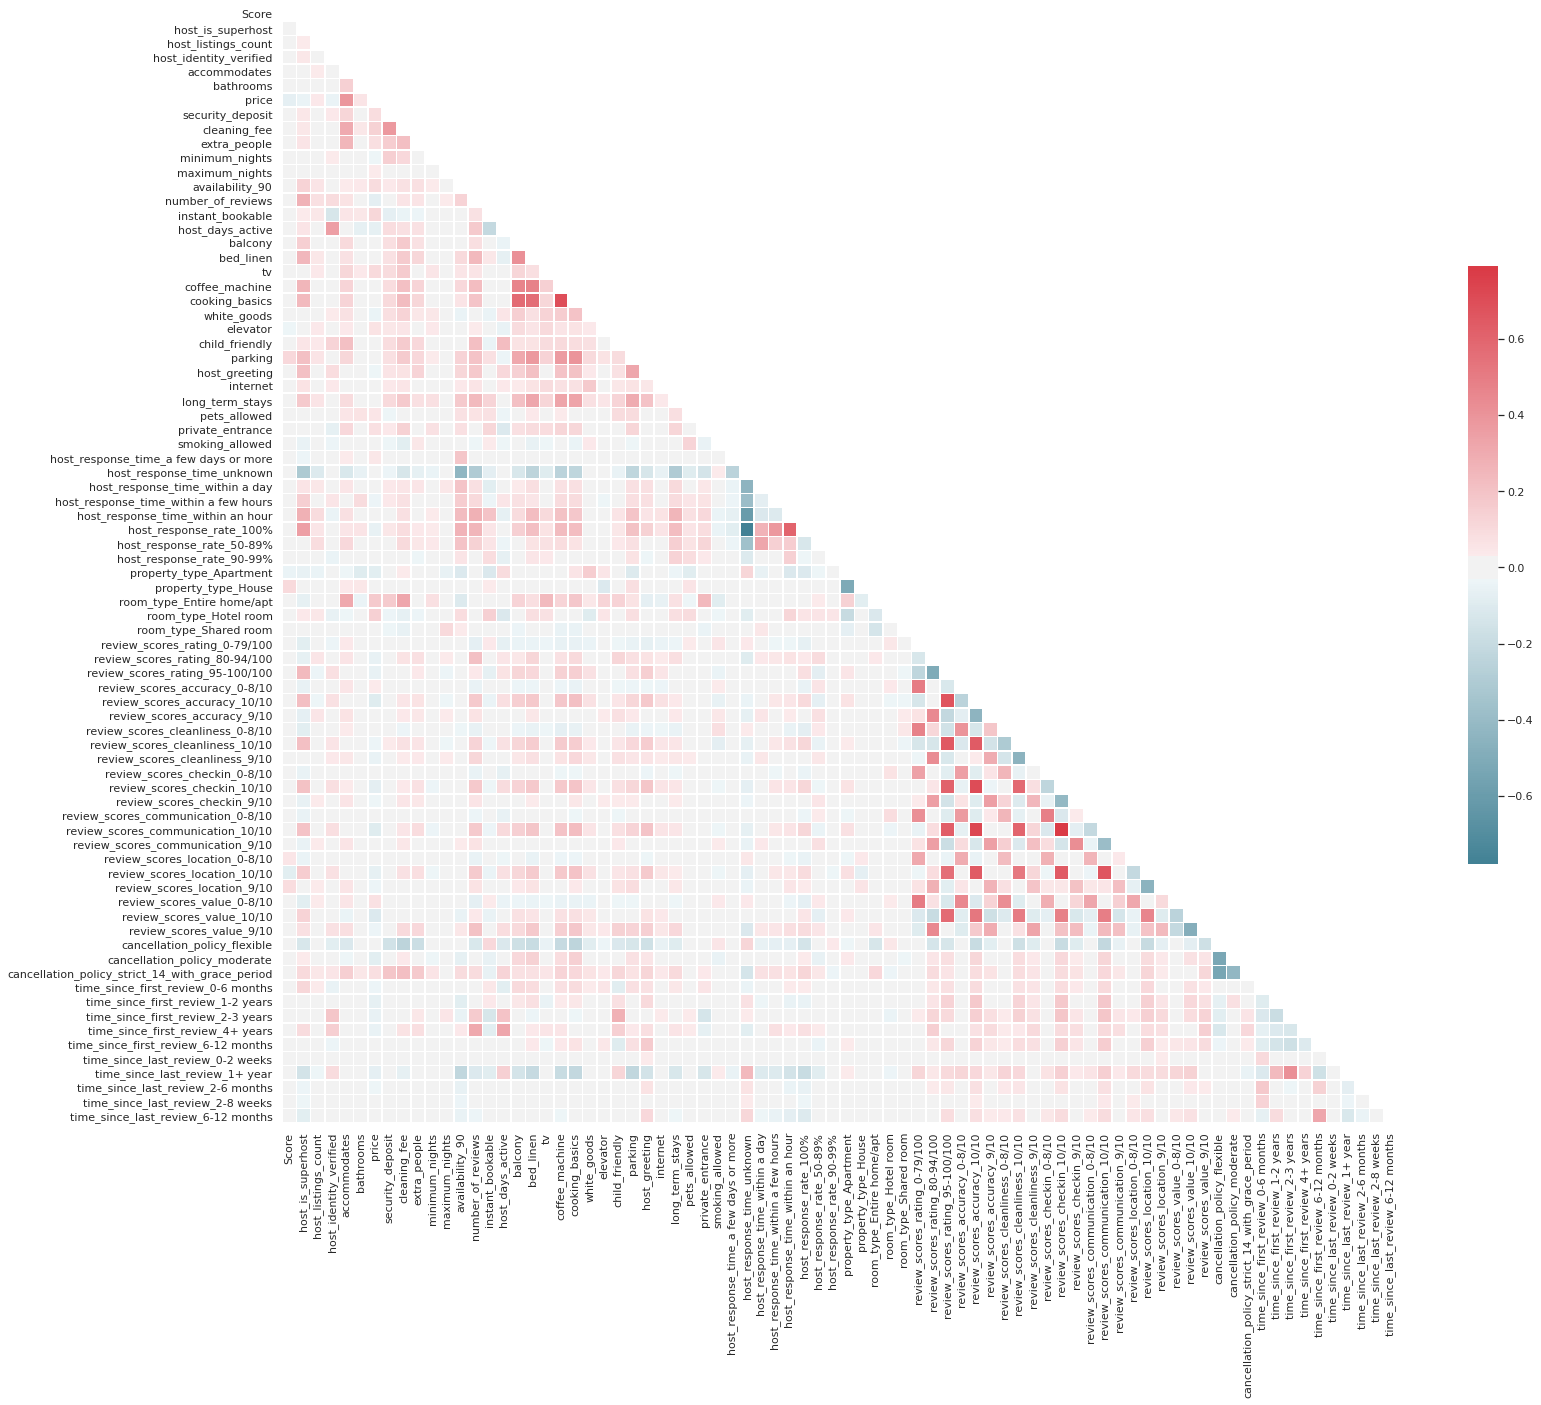

In [146]:
# Final assessment of multi-collinearity
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('Neighbourhood')]), axis=1), figsize=(25,22))

There are still some fairly strong correlations between highly rated properties of different reviews categories - i.e. if a property gets a 10/10 for one category, it is likely to get a 10/10 for other category. However, these will be left in for now and can be experimented with later, to see if removing them improves the model.

__Standardising and normalising__

Other than *availability_90* and *host_days_active*, the remaining numerical features are all positively skewed and could benefit from log transformation

In [147]:
numerical_columns = ['Score','accommodates', 'availability_90', 'bathrooms',
                     'cleaning_fee', 'extra_people', 'host_days_active', 
                     'host_listings_count', 'maximum_nights', 'minimum_nights', 
                     'number_of_reviews', 'price', 'security_deposit']

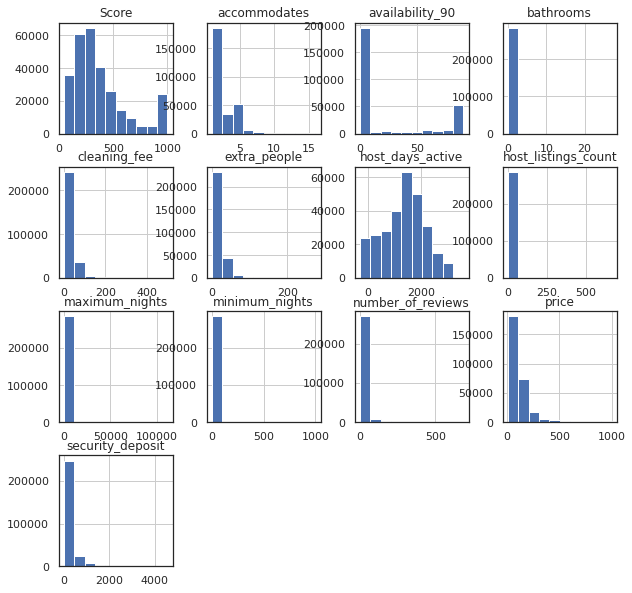

In [148]:
transformed_df[numerical_columns].hist(figsize=(10,10));

In [149]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns 
                     if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])

This appears to have helped some of the distributions, although some (e.g. *cleaning_fee*, *extra_people fee* and *security_fee*) contain a large number of 0s, which means these features are not normally distributed. Most importantly, however, the target variable *price* now appears much more normally distributed.

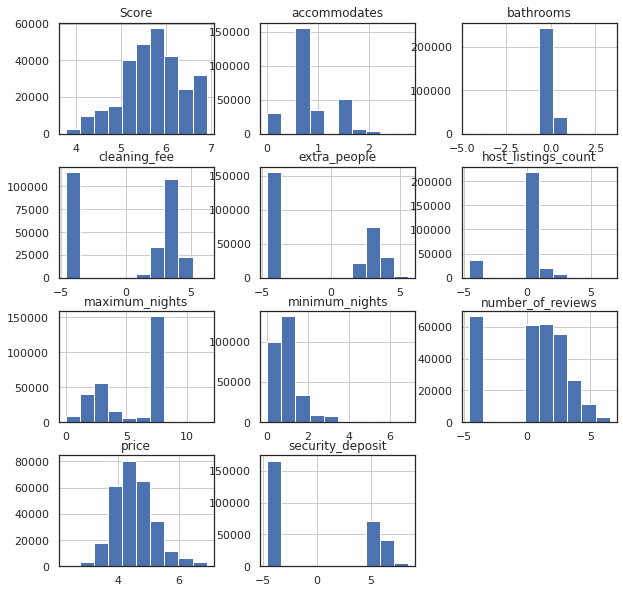

In [150]:
transformed_df[numerical_columns].hist(figsize=(10,10));

Finally, the predictive features X and the target feature y can be separated, and X will be scaled. __*StandardScaler*__ from sklearn will be used, but the type of scaling used could be experimented with later to see if alternative versions yield better results.

That is, we’ll separate the features and the target variable for modeling. We will assign the features (*explanatory variables*) to X and the target variable to y. We use scaler.fit_transform(), as mentioned above, to transform the y variable for the model. transformed_df.drop([features], axis=1) tells pandas which columns we want to exclude. We won’t include price for obvious reasons, and ID is just an index with no relationship to price.

In [151]:
# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

## Modelling

Now that the data preprocessing is over, we can start applying different __*Supervised Machine Learning*__ models. We will compare two models:

A __*Spatial Hedonic Price Model*__ (*OLS Regression*), with the LinearRegression from Scikit-Learn library
The __*Gradient Boosting method*__, with the *XGBRegressor* from the XGBoost library
The evaluation metrics used will be *mean squared error* (for loss) and *r-squared* (for accuracy).

In [152]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

__Model 1: Spatial Hedonic Price Model (HPM)__

The hedonic model involves regressing observed asking-prices for the listing against those attributes of a property hypothesized to be determinants of the asking-price. It comes from __*hedonic price theory*__ which assumes that a commodity, such as a house can be viewed as an aggregation of individual components or attributes [(Griliches, 1971)](https://www.hup.harvard.edu/catalog.php?isbn=9780674592582). Consumers are assumed to purchase goods embodying bundles of attributes that maximize their underlying utility functions [(Rosen, 1974)](https://econpapers.repec.org/article/ucpjpolec/v_3a82_3ay_3a1974_3ai_3a1_3ap_3a34-55.htm).

In addition to the characteristics of the Airbnb listings, we add location features as they have been shown to be important factors in influencing the price (see [here](https://core.ac.uk/download/pdf/35467021.pdf) and [here](https://www.aresjournals.org/doi/abs/10.5555/rees.32.3.d4713v80614728x1) for examples). Ideally, Lagrange multiplier tests should be conducted to verify if there is spatial lag in the dependent variable and therefore a spatial lag model (see [this post](http://darribas.org/gds_scipy16/ipynb_md/08_spatial_regression.html) for spatial regression using [Pysal](https://pypi.org/project/pysal/)) is preferred for estimating a spatial HPM. However, for the purposes of this post, we are only using a conventional OLS model for hedonic price estimation that includes spatial and locational features, but not a spatial lag that accounts for spatial dependence.

So, the first explanatory variables are the listings characteristics (*acommodates*, *bathrooms*, etc) and our second group of explanatory variables based on spatial and locational features are *Score*, which is the network distance to 5th nearest venue we computed with Pandana; and *Neighbourhood belonging*, 1 if the listing belongs to the specified neighbourhood, 0 otherwise.

In [153]:
from sklearn.linear_model import LinearRegression

In [154]:
hpm_reg_start = time.time()

#Create instance of the model, `LinearRegression` function from 
#Scikit-Learn and fit the model on the training data:

hpm_reg = LinearRegression()  
hpm_reg.fit(X_train, y_train) #training the algorithm

#Now that the model has been fit we can make predictions by calling 
#the predict command. We are making predictions on the testing set:

training_preds_hpm_reg = hpm_reg.predict(X_train)
val_preds_hpm_reg = hpm_reg.predict(X_test)

hpm_reg_end = time.time()

print(f"Time taken to run: {round((hpm_reg_end - hpm_reg_start)/60,1)} minutes")

# Check the predictions against the actual values by using the MSE and R-2 metrics:
print("\nTraining RMSE:", round(mean_squared_error(y_train, training_preds_hpm_reg),4))
print("Validation RMSE:", round(mean_squared_error(y_test, val_preds_hpm_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_hpm_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_hpm_reg),4))

Time taken to run: 0.6 minutes

Training RMSE: 0.2799
Validation RMSE: 0.2784

Training r2: 0.4028
Validation r2: 0.4065


This means that our features explain approximately 40% of the variance in our target variable.

Interpreting the mean_squared_error value is somewhat more intuitive than the r-squared value. The RMSE measures the distance between our predicted values and actual values.

We can compare the actual output values for X_test with the predicted values in a dataframe:

In [155]:
y_test_array = np.array(list(y_test))
val_preds_hpm_reg_array = np.array(val_preds_hpm_reg)
hpm_df = pd.DataFrame({'Actual': y_test_array.flatten(), 'Predicted': val_preds_hpm_reg_array.flatten()})
hpm_df

Actual  Predicted
0      5.298317   4.968400
1      3.688879   3.743028
2      4.043051   4.330551
3      4.248495   3.473602
4      4.867534   4.328440
...         ...        ...
57018  4.787492   3.802089
57019  4.094345   4.463144
57020  3.663562   3.716202
57021  5.298317   5.361040
57022  3.496508   4.442728

[57023 rows x 2 columns]

And we can view this relationship graphically with a scatter plot:

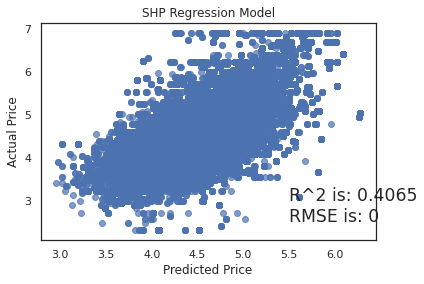

In [156]:
actual_values = y_test
plt.scatter(val_preds_hpm_reg, actual_values, alpha=.7,
            color='b') #alpha helps to show overlapping data
overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                    (round(r2_score(y_test, val_preds_hpm_reg),4)),
                    (round(mean_squared_error(y_test, val_preds_hpm_reg))),4)
plt.annotate( s=overlay,xy=(5.5,2.5),size='x-large')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('SHP Regression Model')
plt.show()

If our predicted values were identical to the actual values, this graph would be the straight line y=x because each predicted value x would be equal to each actual value y.

*Improving our model*

We can try using *Ridge Regularization* to decrease the influence of less important features. *Ridge Regularization* is a process which shrinks the regression coefficients of less important features.

We’ll once again instantiate the model. The *Ridge Regularization model* takes a parameter, *alpha*, which controls the strength of the regularization.

We’ll experiment by looping through a few different values of *alpha*, and see how this changes our results.

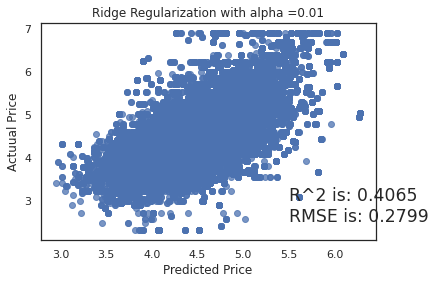

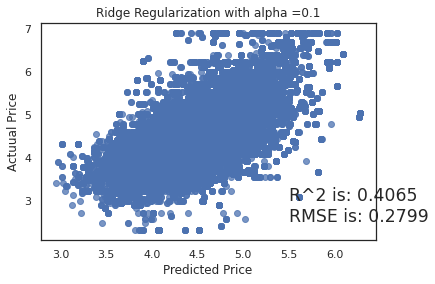

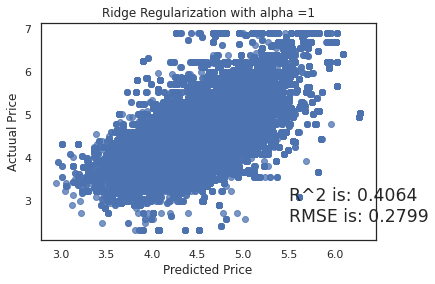

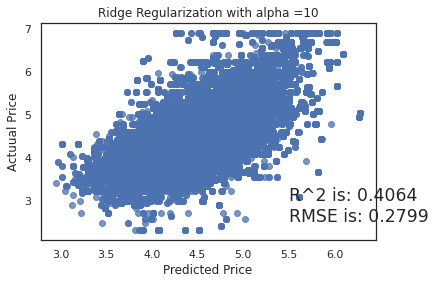

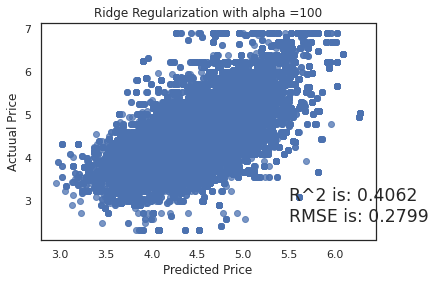

In [157]:
lr = linear_model.LinearRegression()

for i in range(-2,3):
    alpha = 10**i
    rm = linear_model.Ridge(alpha=alpha)
    ridge_model = rm.fit(X_train, y_train)
    preds_ridge = ridge_model.predict(X_test)
    
    plt.scatter(preds_ridge, actual_values, alpha = .75, color = 'b')
    plt.xlabel('Predicted Price')
    plt.ylabel('Actuual Price')
    plt.title('Ridge Regularization with alpha ={}'.format(alpha))
    overlay = 'R^2 is: {}\nRMSE is: {}'.format(
               round(ridge_model.score(X_test, y_test), 4),
               round(mean_squared_error(y_train, training_preds_hpm_reg), 4))
    plt.annotate(s = overlay, xy = (5.5, 2.5), size = 'x-large')
    plt.show()

These models perform almost identically to the first model. In our case, adjusting the alpha did not substantially improve our model.

__Model 2: Gradient boosted decision trees__

*Boosting* is an ensemble technique where new models are added to correct the errors made by existing models. Models are added sequentially until no further improvements can be made. A popular example is the *AdaBoost* algorithm that weights data points that are hard to predict.

*Gradient boosting* is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a *gradient descent algorithm* to minimize the loss when adding new models.

*XGBoost* (e**X**treme **G**radient **Boost**ing) is an implementation of gradient boosted decision trees designed for speed and performance. Is a very popular algorithm that has recently been dominating applied machine learning for structured or tabular data.

This approach supports both *regression* and *classification predictive modeling problems*. For more information see [here](https://www.youtube.com/watch?v=Vly8xGnNiWs) to listen to __*Tianqi Chen*__, the creator of the *XGBoost* library.

This model will most likely provide the best achievable accuracy and a measure of feature importance compared to our Hedonic regression (other than possible small accuracy increases from hyper-parameter tuning) due to XGBoost's superior performance.

In [159]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60, 1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg), 4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg), 4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg), 4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg), 4))

Time taken to run: 6.3 minutes

Training MSE: 0.0739
Validation MSE: 0.0761

Training r2: 0.8423
Validation r2: 0.8378


This means that our features explain approximately 84% of the variance in our target variable.

*Feature importance*

Apart from its superior performance, a benefit of using ensembles of decision tree methods like gradient boosting is that they can automatically provide estimates of *feature importance* from a trained predictive model.

Generally, *importance* provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

This *importance* is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other.

*Importance* is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for. The performance measure may be the purity (Gini index) used to select the split points or another more specific error function.

The feature importances are then averaged across all of the the decision trees within the model.

For more detailed information on how feature importance is calculated in boosted decision trees, see [this](https://stats.stackexchange.com/questions/162162/relative-variable-importance-for-boosting) answer in *StackOverflow*.

In [161]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)
ft_weights_xgb_reg.head(10)

weight
room_type_Hotel room                        0.102616
accommodates                                0.069452
room_type_Entire home/apt                   0.055423
extra_people                                0.026539
Neighbourhood_Altstadt-Lehel                0.022103
host_response_rate_90-99%                   0.021668
host_response_time_unknown                  0.021376
review_scores_rating_80-94/100              0.018396
review_scores_value_10/10                   0.017464
Neighbourhood_Ludwigsvorstadt-Isarvorstadt  0.017123

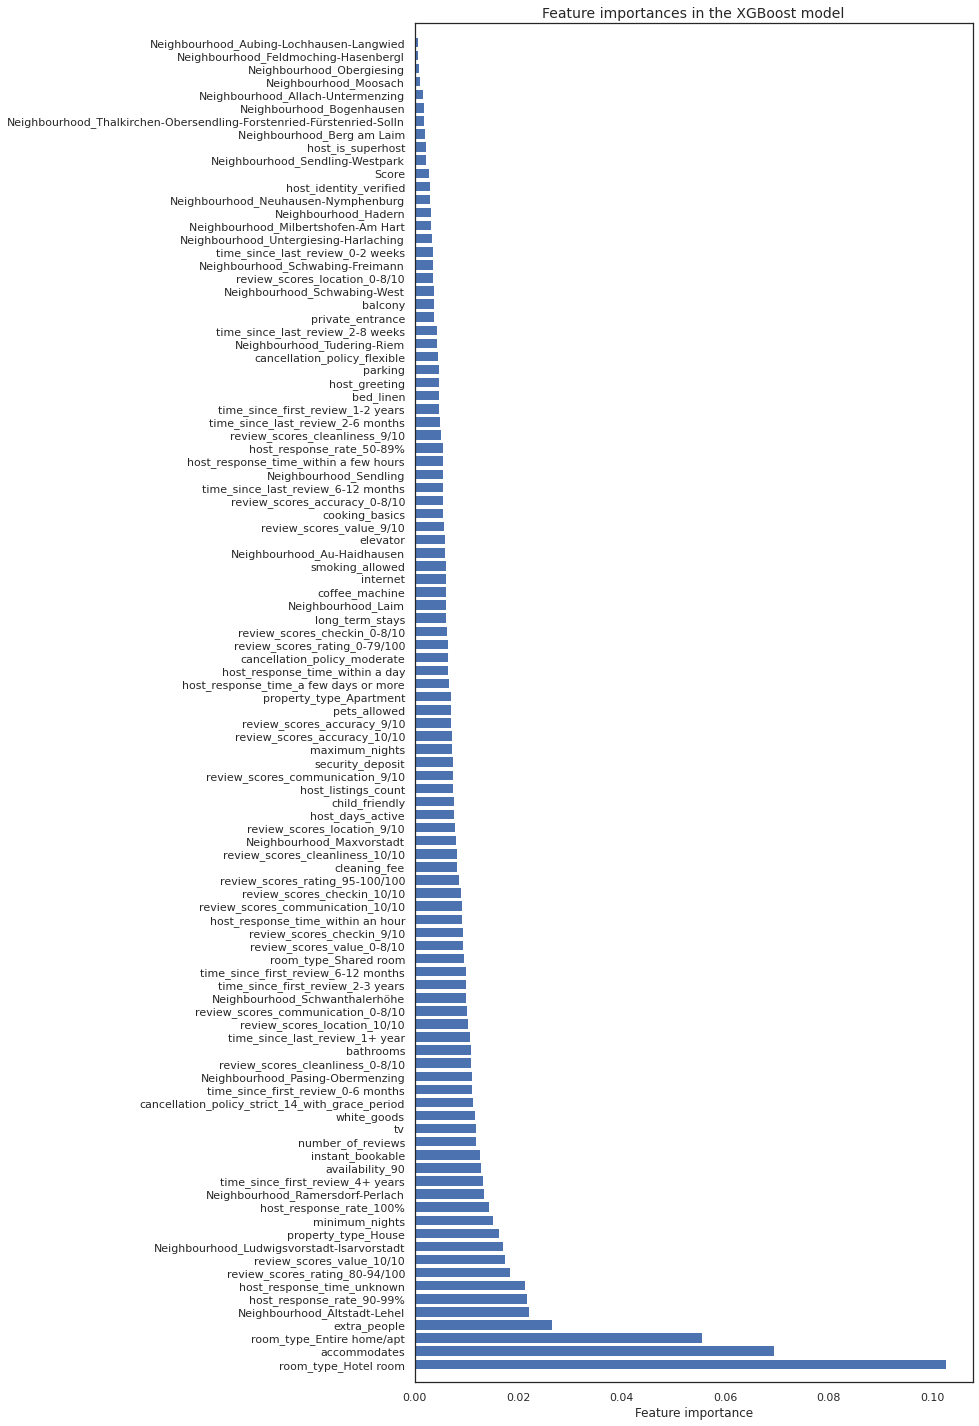

In [162]:
# Plotting feature importances
plt.figure(figsize=(10,25))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

The top 10 most important features are:

1. If the rental is a hotel room type (*room_type-Hotel room*)
2. How many people the property accommodates (*accommodates*)
3. The type of property (*property_type_home/apt*)
4. Is it possible to include additional guests? (*extra_people*)
5. The rental is in the neighbourhood Altstadt-Lehel (*Neighbourhood Altstadt-Lehel*)
6. The rate of hosts responses to messages (*host_response_rate_90-99%*)
7. If the score of review-ratings is over 80% (*review_scores_rating_80-94/100*)
8. The review scores rating is 10/10 (*review_scores_value_10/10*)
9. The rental is in the neighbourhood Ludwigvorstadt-Isarvorstadt (*Neighbourhood_Ludwigvorstadt-Isarvorstadt*)
10. The property type should be a House (*property_type_House*)

The most important feature is the rental being a hotel room. Which makes sense. Guests are giving high marks to the hotels they book on Airbnb. Guests give their stays in boutique hotels, bed and breakfasts, and other hospitality venues booked on Airbnb an average rating of 4.7 out of 5 stars. 
The expanded hotel offerings are making it easier for consumers to use Airbnb to find last-minute accommodations when home hosts are often already booked.

It is not surprising that the second feature is how many people the property accommodates, since that's one of the main things you would use to search for properties in the first place.

We can observe that belonging to a certain neighbourhood increases price more than others and it shows some importance, but it's rather of moderate importance compared to the top 3 features. 
It is also important to be able to include additional guests, and the price is usually higher than having the included guest from the beginning.
Review Scores Value is higher on the importance list (number 8). This is, it is likely renters put more weight in the value of the location instead of judging the location based on neighbourhood and venues around the property. This could also be because Munich is a small and walkable city with good transportation services. Thus, location is not a major problem to reaching main touristic attractions and amenities.

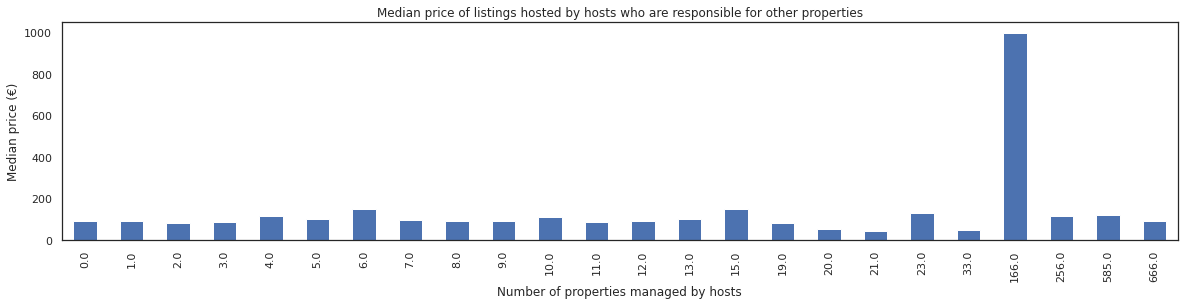

In [163]:
# Median price for different host listing counts
plt.figure()
df_merged.groupby('host_listings_count').price.median().plot(figsize=(20,4), kind='bar')
plt.title('Median price of listings hosted by hosts who are responsible for other properties')
plt.xlabel('Number of properties managed by hosts')
plt.ylabel('Median price (€)');

*Improving models*

In the "Preparing the data for modeling" section above, it was noted that a lot of the review columns are reasonably highly correlated with each other. They were left in to see whether they would be useful after all. However, the feature importances graph produced by the XGBoost model suggest that they were of relatively low importance.

This model will drop review columns other than the overall review rating, and use the same Hedonic regression and XGBoost structure, in order to see whether this produces a better models.

Columns will be dropped from the existing X_train and X_test split, for consistency.

In [164]:
all_review = list(X_train.columns[X_train.columns.str.startswith("review_scores")])
review_to_keep = list(X_train.columns[X_train.columns.str.startswith("review_scores_rating")])
review_to_drop = [x for x in all_review if x not in review_to_keep]

X_train_short = X_train.drop(review_to_drop, axis=1)
X_test_short = X_test.drop(review_to_drop, axis=1)

__Model 3: Hedonic regression with dropped columns__

In [165]:
hpm_reg_start = time.time()

# Create instance of the model, `LinearRegression` function from 
# Scikit-Learn and fit the model on the training data:

hpm_reg2 = LinearRegression()  
hpm_reg2.fit(X_train, y_train) #training the algorithm

# Now that the model has been fit we can make predictions by calling 
# the predict command. We are making predictions on the testing set:
training_preds_hpm_reg2 = hpm_reg2.predict(X_train)
val_preds_hpm_reg2 = hpm_reg2.predict(X_test)

hpm_reg_end = time.time()

print(f"Time taken to run: {round((hpm_reg_end - hpm_reg_start)/60,1)} minutes")

# Check the predictions against the actual values by using the MSE and R-2 metrics:
print("\nTraining RMSE:", round(mean_squared_error(y_train, training_preds_hpm_reg2),4))
print("Validation RMSE:", round(mean_squared_error(y_test, val_preds_hpm_reg2),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_hpm_reg2),4))
print("Validation r2:", round(r2_score(y_test, val_preds_hpm_reg2),4))

Time taken to run: 0.5 minutes

Training RMSE: 0.2799
Validation RMSE: 0.2784

Training r2: 0.4028
Validation r2: 0.4065


**Model 4: XG Boost with dropped columns**

In [166]:
xgb_reg_start = time.time()

xgb_reg2 = xgb.XGBRegressor()
xgb_reg2.fit(X_train, y_train)
training_preds_xgb_reg2 = xgb_reg2.predict(X_train)
val_preds_xgb_reg2 = xgb_reg2.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60, 1)}minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg2), 4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg), 4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg), 4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg), 4))

Time taken to run: 6.2minutes

Training MSE: 0.0739
Validation MSE: 0.0761

Training r2: 0.8423
Validation r2: 0.8378


Both Spatial Hedonic Regression and XGBoost perform almost exactly the same without the additional review columns.

Hence, because they are able to achieve the same performance with 18 fewer columns, the second models are the preferred models as they require less data and are less computationally expensive.

*Final model selection*

Overall, the XGBoost model (*Model 4*) is the preferred model, which performs better than both Spatial Hedonic Regression Models and just as good as the first model but is less computationally expensive. It could possibly be improved further with hyper-parameter tuning.

## 4. Conclusion

The best performing model was able to predict 84.23% of the variation in price with an RMSE of 0.07. Which means we still have a remaining 15.77% unexplained. This could be due to other features that are not part of our dataset or the lack of need to analyse our features more closely.

For example, given the importance of customer reviews of the listing in determining price, perhaps a better understanding of the reviews could improve the prediction. Using Sentiment Analysis, a score between -1 (very negative sentiment) and 1 (very positive sentiment) can be assigned to each review per listing property. The scores are then averaged across all the reviews associated with that listing and the final scores can be included as a new feature in the model (see [here](https://arxiv.org/pdf/1907.12665.pdf) for an example).

Another suggestion is the inclusion of image quality as a feature. Using Difference-in-Difference deep learning and supervised learning analyses on a Airbnb panel dataset, researchers found that units with verified photos (taken by Airbnb’s photographers) generate additional revenue per year on average (see [here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2976021)).

It was noticeable that reviews about listing location, rather than the location features themselves, were higher in the feature importance list. Thus, this finding could perhaps be used by Airbnb hosts when writing their listing's description. Highlighting accessibility and location benefits of staying with them could perhaps benefit them and how much they can ask for their listing.

## 5. References

* Marco Peixeiro. 2019 - The Complete Guide to Time Series Analysis and Forecasting. Available at: https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775

* Kuan Butts. 2017 – Point of Interest Accessibility. Available at: http://kuanbutts.com/2017/08/08/how-to-pdna/ 

* Geoff Boeing. 2016 - How to Visualize Urban Accessibility and Walkability. Available at: https://geoffboeing.com/2016/07/visualize-urban-accessibility-walkability/

* Kalehbasti, Pouya & Nikolenko, Liubov & Rezaei, Hoormazd. (2019) - Airbnb Price Prediction Using Machine Learning and Sentiment Analysis. Available at: https://arxiv.org/pdf/1907.12665.pdf

* J. Elith, J. R. Leathwick, T. Hastie. (2008) - A working guide to boosted regression trees. Journal of Animal Ecology. Available at: https://besjournals.onlinelibrary.wiley.com/doi/full/10.1111/j.1365-2656.2008.01390.x

* Zhang, Shunyuan and Lee, Dokyun (DK) and Singh, Param Vir and Srinivasan, Kannan. (2017) - How Much Is an Image Worth? Airbnb Property Demand Estimation Leveraging Large Scale Image Analytics. Available at SSRN: https://ssrn.com/abstract=2976021 or http://dx.doi.org/10.2139/ssrn.2976021

* Chen, T., Guestrin, C., (2016) - XGBoost: A Scalable Tree Boosting System, Proceeding KDD '16 Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, Pages 785-794. Available at: https://dl.acm.org/citation.cfm?id=2939785

* Rosen, Sherwin, (1974) - Hedonic Prices and Implicit Markets: Product Differentiation in Pure Competition, Journal of Political Economy, 82, issue 1, p. 34-55, https://EconPapers.repec.org/RePEc:ucp:jpolec✌️82:y:1974:i:1:p:34-55.

* Liv Osland (2010) - An Application of Spatial Econometrics in Relation to Hedonic House Price Modeling. Journal of Real Estate Research: 2010, Vol. 32, No. 3, pp. 289-320. Available at: https://www.aresjournals.org/doi/abs/10.5555/rees.32.3.d4713v80614728x1

* Luxen, D. and Vetter, C. (2011) - Real-time routing with OpenStreetMap data. Proceedings of the 19th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, New York, NY, USA,Available at: http://doi.acm.org/10.1145/2093973.2094062

* Limsombunchai, V., (2004) - House Price Prediction: Hedonic Price Model vs. Artificial Neural Network, Paper presented at the 2004 NZARES Conference Blenheim Country Hotel, Blenheim, New Zealand. Available at: https://core.ac.uk/download/pdf/35467021.pdf

* Fletcher, F, and Waddell, P. (2012) - A Generalized Computational Framework for Accessibility: From the Pedestrian to the Metropolitan Scale. Transportation Research Board Annual Conference Available at: http://onlinepubs.trb.org/onlinepubs/conferences/2012/4thITM/Papers-A/0117-000062.pdf
